# Predicción de Atraso en Despegues

### 0. Ambiente local de desarrollo

El ambiente de desarrollo local fue configurado utilizando las siguientes herramientas:

+ **Poetry** versión 1.1.13
+ **Pyenv** versión 2.3.3
+ **Virtualenv** versión 20.16.4

El ambiente virtual se activa con el siguiente comando: 

+ **source .venv/bin/activate**

### 1. Librerias 

In [1]:
#### Análisis exploratorio #################
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt

#### Muestreo y transformación de variables
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

#### Modelamiento ##########################
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#### Evaluación Modelos ####################
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics

#### Configuración #########################
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

### 2. Descripción del Dataset 

El dataset describe los despegues y los datos relacionados al vuelo desde el terminal aéreo de Santiago (SCL)

### 2.1 Descripción de las columnas

1. **Fecha-I** : Fecha y hora programada del vuelo. 
2. **Vlo-I**   : Número de vuelo programado.
3. **Ori-I**   : Código de ciudad de origen programado. 
4. **Des-I**   : Código de ciudad de destino programado. 
5. **Emp-I**   : Código aerolínea de vuelo programado. 
6. **Fecha-O** : Fecha y hora de operación del vuelo.
7. **Vlo-O**   : Número de vuelo de operación del vuelo.
8. **Ori-O**   : Código de ciudad de origen de operación.
9. .**Des-O**  : Código de ciudad de destino de operación.
10. **Emp-O**  : Código aerolínea de vuelo operado.
11. **DIA**    : Día del mes de operación del vuelo.
12. **MES**    : Número de mes de operación del vuelo.
13. **AÑO**       : Año de operación del vuelo.
14. **DIANOM**    : Día de la semana de operación del vuelo. 
15. **TIPOVUELO** : Tipo de vuelo, I =Internacional, N =Nacional. 
16. **OPERA**     : Nombre de aerolínea que opera.
16. **SIGLAORI**  : Nombre ciudad origen.
17. **SIGLADES**  : Nombre ciudad destino.

### 3. Carga datos 

In [2]:
# Definición ruta acceso a los datos

DATA = Path('/Users/claudiocollaobahamondes/Desktop/desafio/pred_atraso_vuelos/data')

# Validación si existe la carpeta data
DATA.exists()

True

In [3]:
# Por definición se fuerza a las columnas Fecha-I y Fecha-O tengan formato de fecha cuando se cargan los datos

df=pd.read_csv(DATA/'dataset_SCL.csv',parse_dates=['Fecha-I','Fecha-O'],infer_datetime_format=True)

In [4]:
# Tamaño del datset

df.shape

(68206, 18)

In [5]:
# Validación de los formatos por columna

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Fecha-I    68206 non-null  datetime64[ns]
 1   Vlo-I      68206 non-null  object        
 2   Ori-I      68206 non-null  object        
 3   Des-I      68206 non-null  object        
 4   Emp-I      68206 non-null  object        
 5   Fecha-O    68206 non-null  datetime64[ns]
 6   Vlo-O      68205 non-null  object        
 7   Ori-O      68206 non-null  object        
 8   Des-O      68206 non-null  object        
 9   Emp-O      68206 non-null  object        
 10  DIA        68206 non-null  int64         
 11  MES        68206 non-null  int64         
 12  AÑO        68206 non-null  int64         
 13  DIANOM     68206 non-null  object        
 14  TIPOVUELO  68206 non-null  object        
 15  OPERA      68206 non-null  object        
 16  SIGLAORI   68206 non-null  object       

In [6]:
# Los números de vuelo se confirman como variables  categóricas

df['Vlo-I'] = df['Vlo-I'].apply(lambda x: str(x))
df['Vlo-O'] = df['Vlo-O'].apply(lambda x: str(x))

 **Comentarios carga de los datos**

+ No se modificará el formato del resto de las variables dado que aquellas que identifican el vuelo es correcto el formato categorico y las relacionadas con la fecha del vuelo es correcto que sean numéricas.

### 4. Análisis Exploratorio

### 4.1 Análisis Variables Categóricas

In [7]:
# Creación dataset con variables categóricas

categoricas = df.select_dtypes(include=[object])

In [8]:
# Columnas dataset variables categóricas

categoricas.columns

Index(['Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Vlo-O', 'Ori-O', 'Des-O', 'Emp-O',
       'DIANOM', 'TIPOVUELO', 'OPERA', 'SIGLAORI', 'SIGLADES'],
      dtype='object')

In [9]:
#Visualización muestra de las variables categóricas

categoricas.head()

,Vlo-I,Ori-I,Des-I,Emp-I,Vlo-O,Ori-O,Des-O,Emp-O,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,226,SCEL,KMIA,AAL,226,SCEL,KMIA,AAL,Domingo,I,American Airlines,Santiago,Miami
1,226,SCEL,KMIA,AAL,226,SCEL,KMIA,AAL,Lunes,I,American Airlines,Santiago,Miami
2,226,SCEL,KMIA,AAL,226,SCEL,KMIA,AAL,Martes,I,American Airlines,Santiago,Miami
3,226,SCEL,KMIA,AAL,226,SCEL,KMIA,AAL,Miercoles,I,American Airlines,Santiago,Miami
4,226,SCEL,KMIA,AAL,226,SCEL,KMIA,AAL,Jueves,I,American Airlines,Santiago,Miami


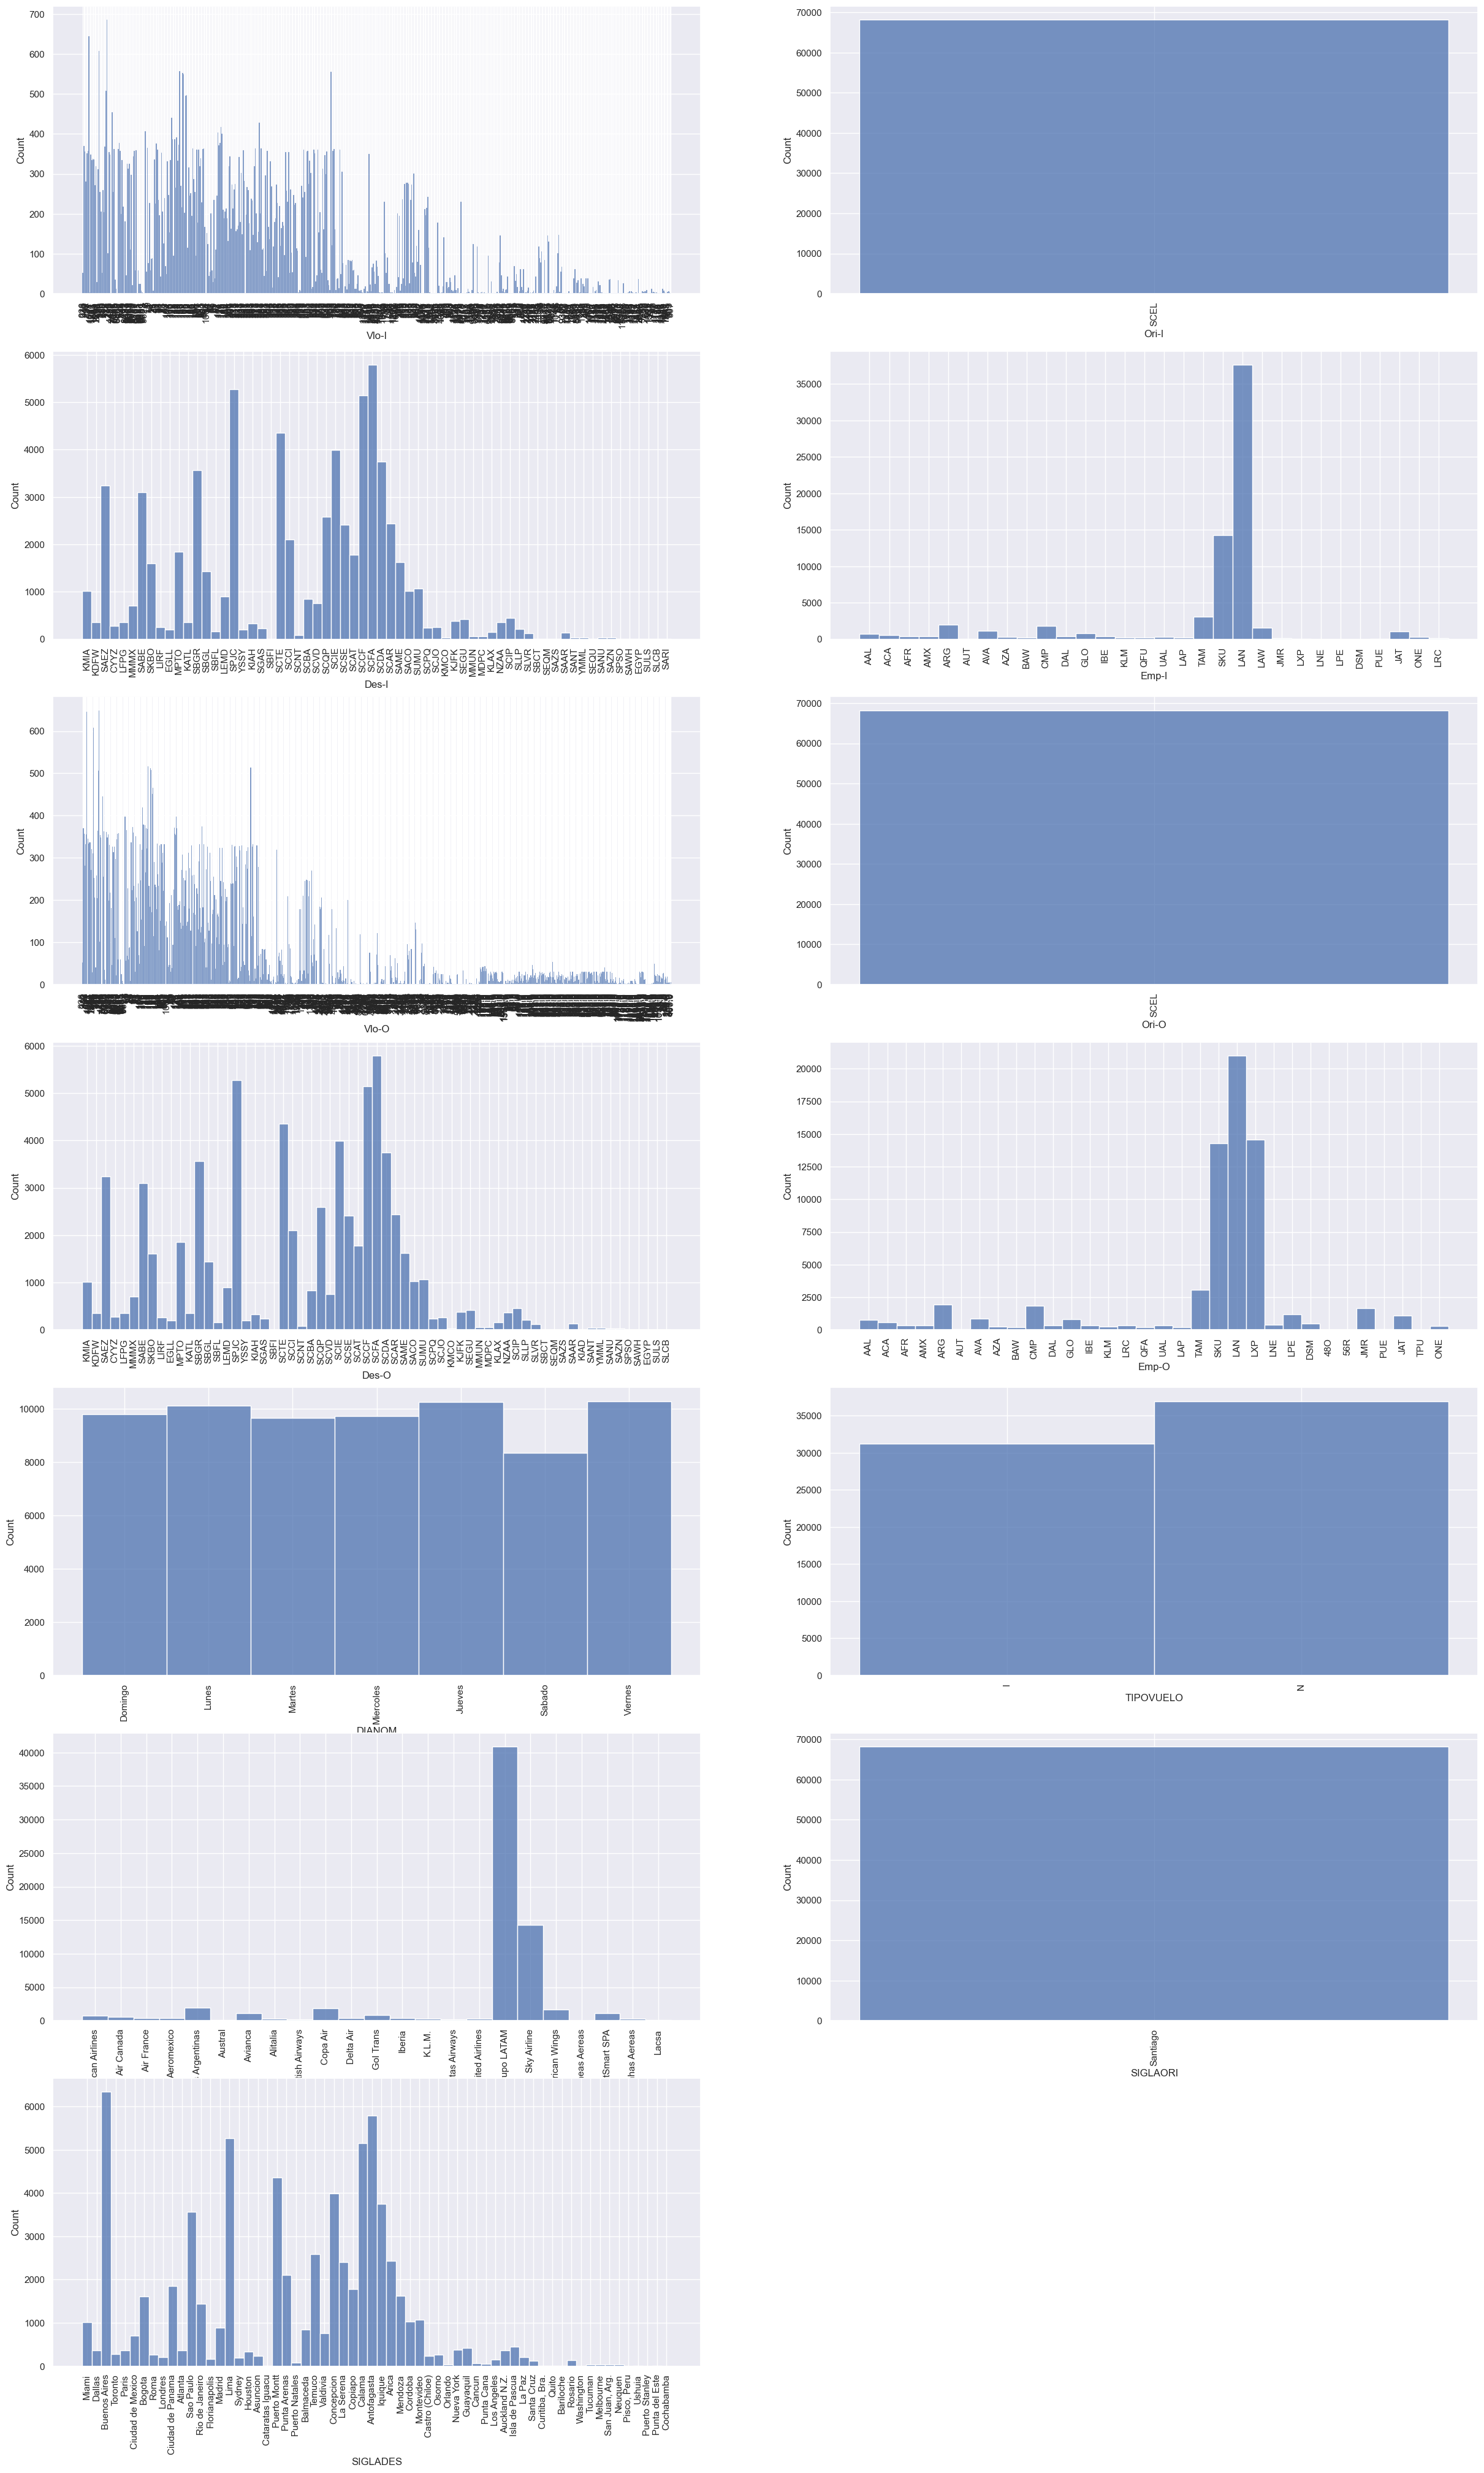

In [10]:
# Visualización variables categóricas


plt.figure(figsize=(30,50))

for i,col in enumerate(categoricas.columns,1):
    plt.subplot(7,2,i)
    sns.histplot(data=categoricas, x=col)
    plt.xticks(rotation=90)
plt.show()

**Comentarios análisis gráfico variables categóricas**

+ Se observa que las variables Ori-I, Ori-O y SIGLAORI tienen un solo valor, por lo tanto no se consideran para el modelamiento.

+ Si bien se observa similitud entre las variables Emp-I y Emp-O se aprecian diferencias. Se profundizará en el análisis de estas diferencias. 

+ Si bien se observa similitud entre las variables Vlo-I y Vlo-O se aprecian diferencias. Se profundizará en el análisis de estas diferencias. 


### 4.1.1 Análisis de Diferencias Entre Variables Des, Vlo y Emp

In [11]:
# Validación que los datos de origen y destino en las variables destino,
# número de vuelo y empresa que realiza el vuelo.

df['diff_des'] = np.where(df['Des-I'] == df['Des-O'],1,0)
df['diff_vlo'] = np.where(df['Vlo-I'] == df['Vlo-O'],1,0)
df['diff_emp'] = np.where(df['Emp-I'] == df['Emp-O'],1,0)

In [12]:
# Cantidad de destinos operados distintos a los programados

df['diff_des'].value_counts()

1    68178
0       28
Name: diff_des, dtype: int64

In [13]:
# Cantidad de número de vuelos operados distintos a los programados 

df['diff_vlo'].value_counts()

1    63687
0     4519
Name: diff_vlo, dtype: int64

In [14]:
# Cantidad de empresas distintas a las empresas programadas

df['diff_emp'].value_counts()

1    49537
0    18669
Name: diff_emp, dtype: int64

**Comentarios análisis diferencias variables Des,Vlo y Emp**

+ Se observa que en las tres variables hay diferencias entre lo programado y lo operado.

+ Las mayores diferencias se encuentran en las variables Emp y Vlo. Dada esta magnitud se incorporará en el modelamiento una variable dummy señalando que hay diferencias entre estas variables.

+ Se produndizará el análisis de estas diferencias.

In [15]:
# Validación de la relación entre la empresa planificada y la que opero el vuelo.

df.groupby(['Emp-I','Emp-O','OPERA']).agg({'OPERA':'count'})

OPERA
Emp-I Emp-O OPERA                          
AAL   AAL   American Airlines           757
ACA   ACA   Air Canada                  565
AFR   AFR   Air France                  358
AMX   AMX   Aeromexico                  351
ARG   ARG   Aerolineas Argentinas      1944
      AUT   Aerolineas Argentinas         5
AUT   ARG   Austral                       2
      AUT   Austral                      72
AVA   AVA   Avianca                     885
      LRC   Avianca                     265
      TPU   Avianca                       2
AZA   AZA   Alitalia                    259
BAW   BAW   British Airways             205
CMP   CMP   Copa Air                   1850
DAL   DAL   Delta Air                   358
DSM   DSM   Grupo LATAM                   2
GLO   GLO   Gol Trans                   806
IBE   IBE   Iberia                      362
JAT   JAT   JetSmart SPA               1095
JMR   JMR   Latin American Wings        100
KLM   KLM   K.L.M.                      251
LAN   DSM   Grupo LATAM                 491
      LAN   Grupo LATAM               20988
      LNE   Grupo LATAM                 373
      LPE   Grupo LATAM                1210
      LXP   Grupo LATAM               14549
LAP   LAP   Grupo LATAM                 216
LAW   48O   Latin American Wings         10
      56R   Latin American Wings         17
      JMR   Latin American Wings       1547
LNE   LNE   Grupo LATAM                   1
LPE   LPE   Grupo LATAM                   4
LRC   LRC   Lacsa                        92
LXP   LXP   Grupo LATAM                   9
ONE   ONE   Oceanair Linhas Aereas      279
PUE   PUE   Plus Ultra Lineas Aereas     49
QFU   QFA   Qantas Airways              195
SKU   SKU   Sky Airline               14298
TAM   LAP   Grupo LATAM                   3
      TAM   Grupo LATAM                3046
UAL   UAL   United Airlines             335

**Comentarios análisis relación entre la empresa planificada y la que opero el vuelo**

+ Si bien no se observa vuelos que cambian de empresa, por ejemplo de Latam a Aerolineas Argentinas, se observan cambios en filiales. Un ejemplo es Latam. Esto reafirma que se debe incorporar en el modelamiento una variable que refleje este cambio y que efecto tiene en el atraso.

In [16]:
# Validación de la relación entre las columnas Des-I, Des-O y SiglaDes

df.groupby(['Des-I','Des-O','SIGLADES']).agg({'SIGLADES':'count'}).tail(40)

SIGLADES
Des-I Des-O SIGLADES                 
SBGR  SBGR  Sao Paulo            3569
SCAR  SCAR  Arica                2436
SCAT  SCAT  Copiapo              1780
SCBA  SCBA  Balmaceda             839
      SCTE  Puerto Montt            4
SCCF  SCCF  Calama               5145
SCCI  SCCI  Punta Arenas         2104
      SCTE  Puerto Montt            1
SCDA  SCDA  Iquique              3747
SCFA  SCCF  Calama                  1
      SCFA  Antofagasta          5786
SCIE  SCIE  Concepcion           3993
      SCQP  Temuco                  1
      SCTE  Puerto Montt            1
SCIP  SCIP  Isla de Pascua        452
SCJO  SCJO  Osorno                259
SCNT  SCNT  Puerto Natales         79
SCPQ  SCPQ  Castro (Chiloe)       235
SCQP  SCQP  Temuco               2583
SCSE  SCSE  La Serena            2410
SCTE  SCCI  Punta Arenas            1
      SCQP  Temuco                  5
      SCTE  Puerto Montt         4351
SCVD  SCVD  Valdivia              753
SEGU  SABE  Buenos Aires            1
      SEGU  Guayaquil             422
SEQM  SEQM  Quito                   1
SEQU  SEQM  Quito                   1
SGAS  SGAS  Asuncion              232
SKBO  SKBO  Bogota               1604
SLCB  SLCB  Cochabamba              1
SLLP  SLLP  La Paz                209
SLVR  SLVR  Santa Cruz            120
SPJC  SPJC  Lima                 5270
SPSO  SPSO  Pisco, Peru             1
SULS  SULS  Punta del Este          6
SUMU  SUMU  Montevideo           1066
YMML  YMML  Melbourne              38
YSSY  YMML  Melbourne               1
      YSSY  Sydney                194

**Comentarios análisis validación de la relación entre las columnas Des-I, Des-O y SiglaDes**

+ Se valida que los verdaderos cambios de destino fueron: 

    + Whashington - Houston: 1
    + Rio de Janeiro - Sao Pablo: 1
    + Melbourne - Sydney: 1
    + Guayaquil - Buenos aíres:1
    + Balmaceda - Puerto Montt: 4
    + Punta Arenas - Puerto Montt: 1
    + Antofagasta - Calama: 1
    + Concepción - Temuco : 1
    + Concepción - Puerto Montt : 1
    + Punta Arenas - Temuco: 1
    + Puerto Montt  - Punta Arenas: 1
    + Guayaquil - Buenos Aires: 1
    + Sydney - Melbourne: 1
 
+ Si bien son pocos se investigará el impacto en el atraso.

### 4.2 Análisis Variables Numéricas

In [17]:
numericas = df.select_dtypes(include=[int])

In [18]:
numericas.columns[:3]

Index(['DIA', 'MES', 'AÑO'], dtype='object')

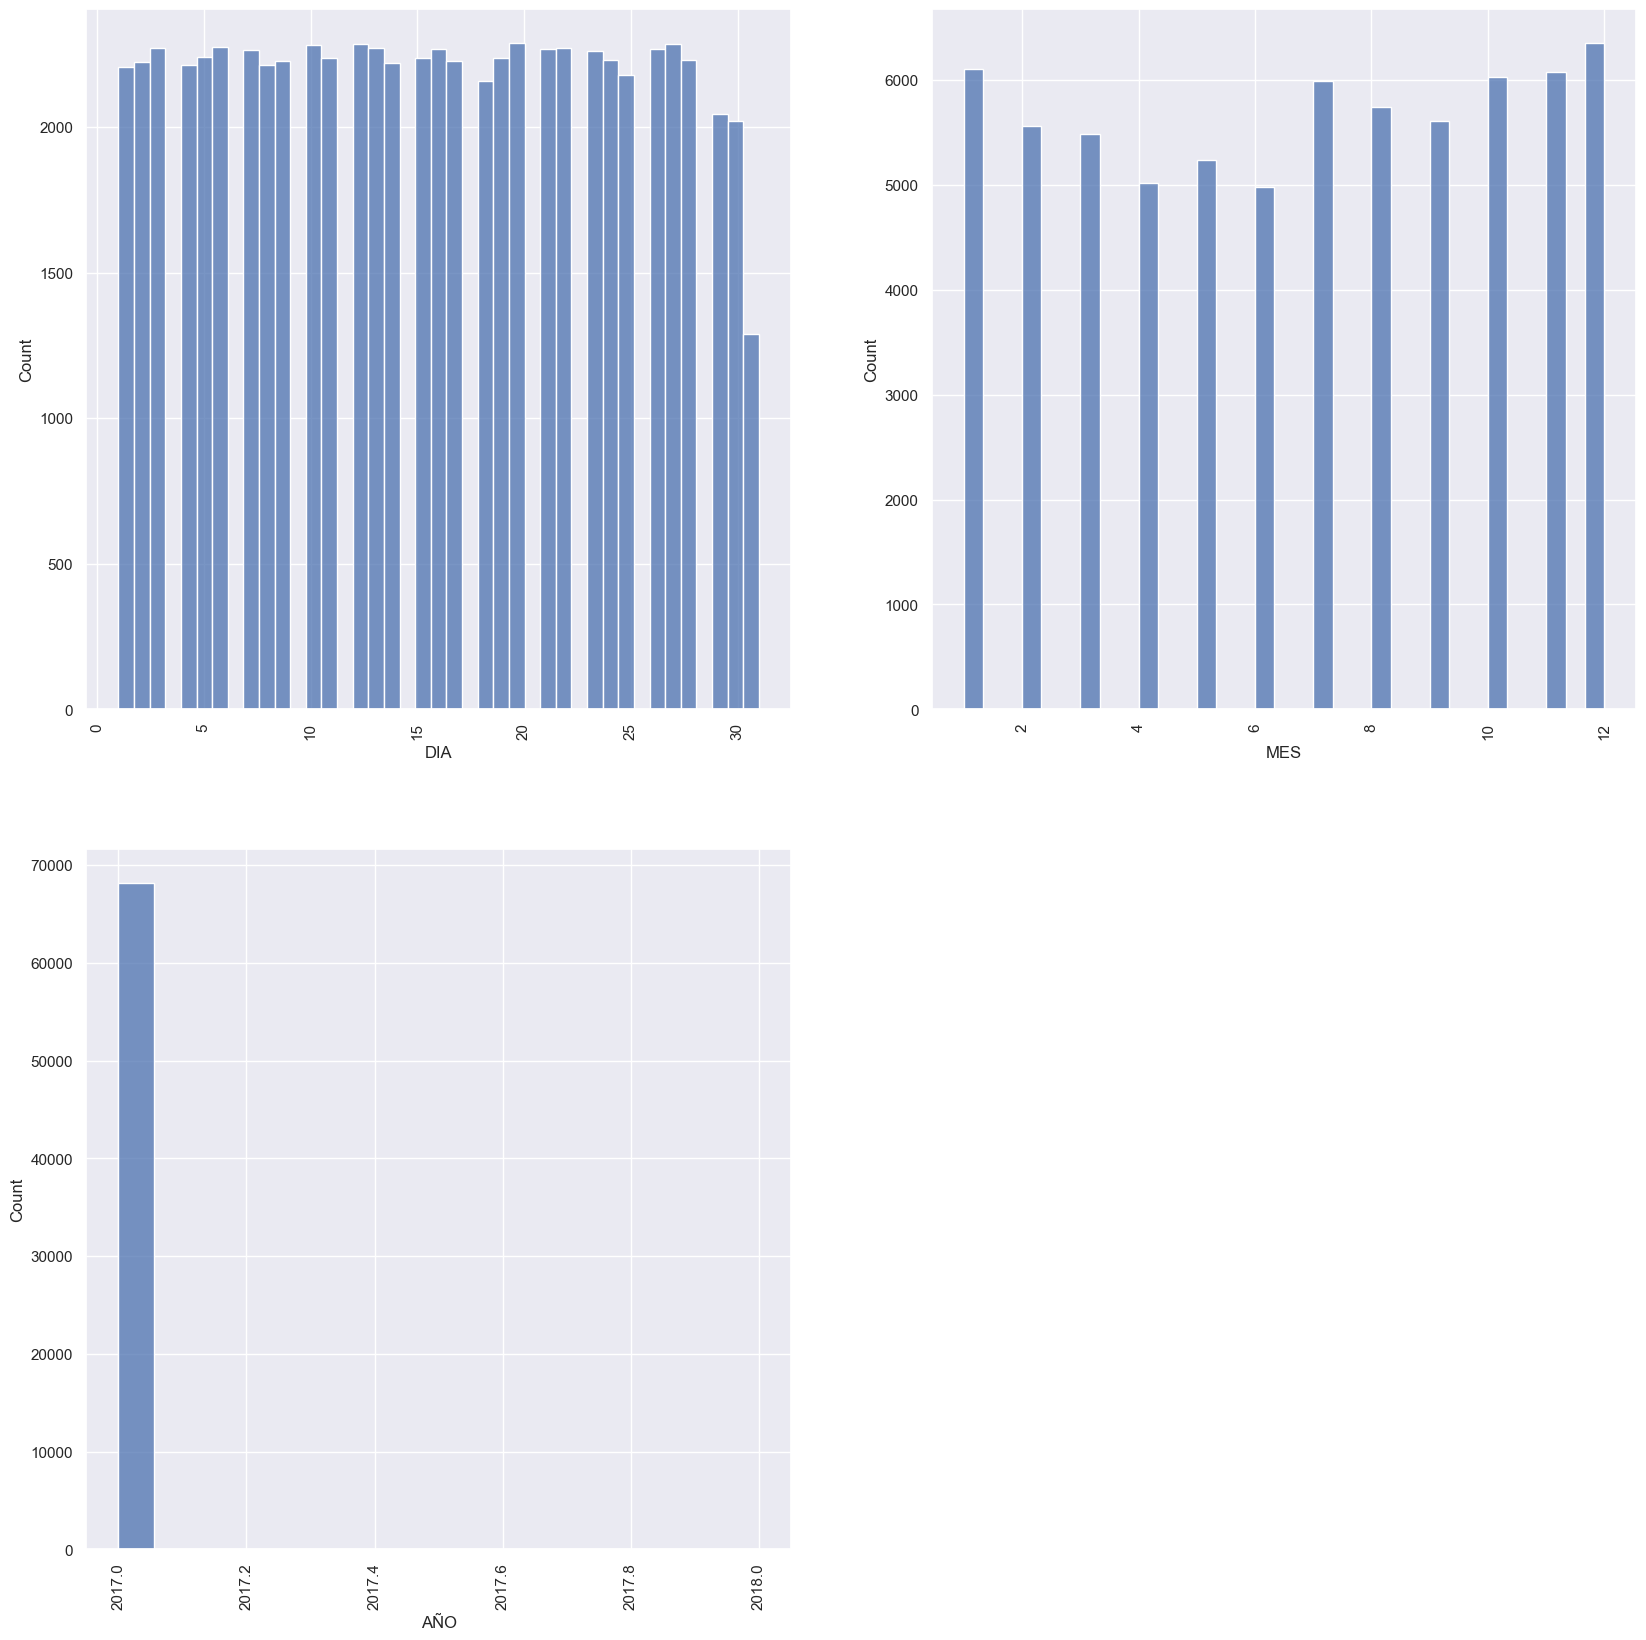

In [19]:
# Visualización variables númericas

plt.figure(figsize=(20,20))

for i,col in enumerate(numericas.columns[:3],1):
    plt.subplot(2,2,i)
    sns.histplot(data=numericas, x=col)
    plt.xticks(rotation=90)

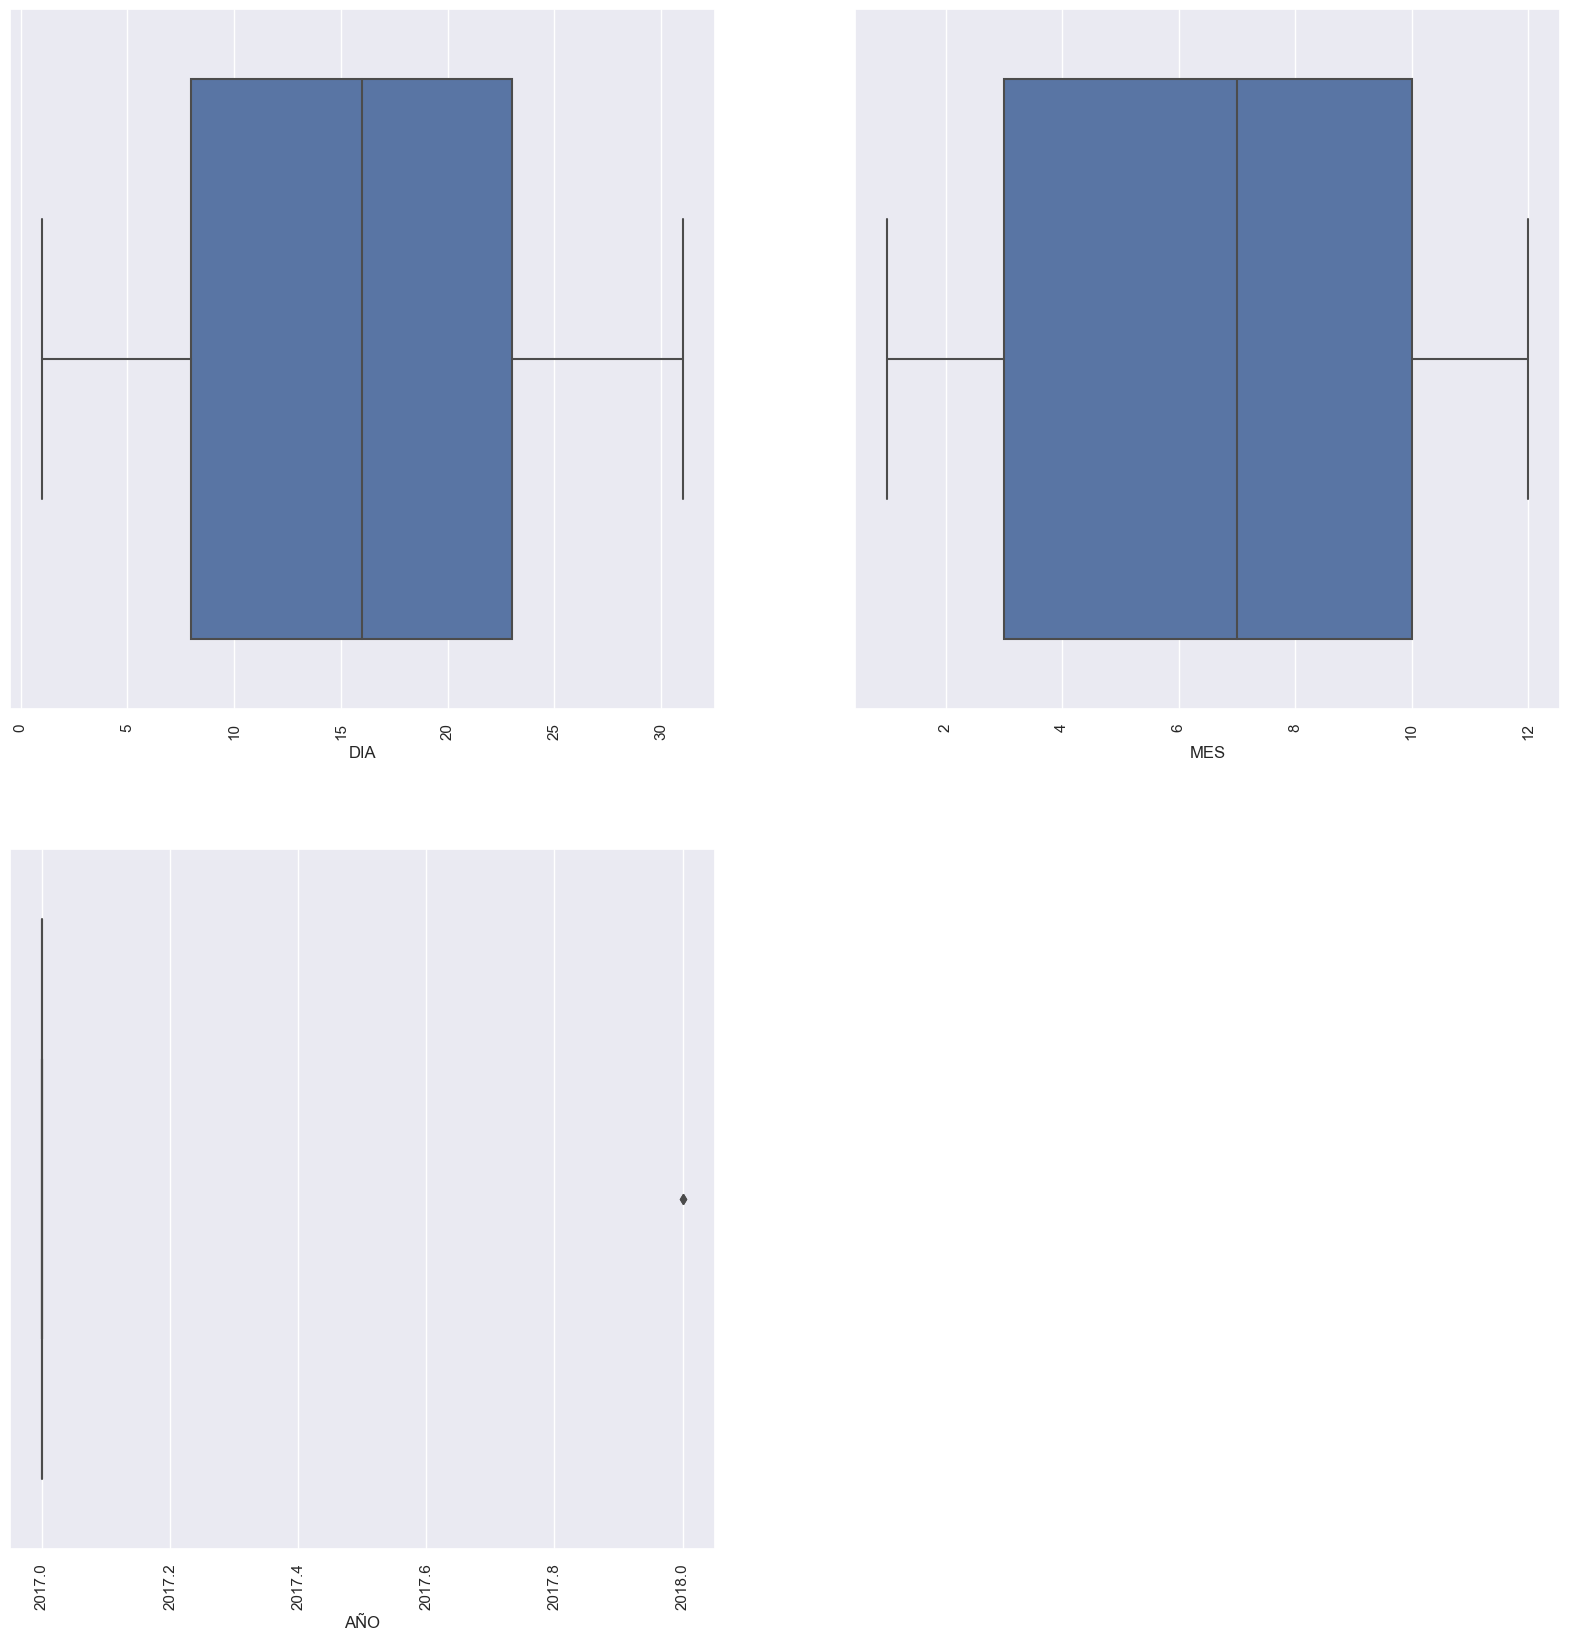

In [20]:
# Visualización boxplot variables númericas

plt.figure(figsize=(20,20))

for i,col in enumerate(numericas.columns[:3],1):
    plt.subplot(2,2,i)
    sns.boxplot(data=numericas, x=col)
    plt.xticks(rotation=90)

**Comentarios análisis gráfico variables númericas**

+ Se observa que la Año tienen un solo valor, por lo tanto no se consideran para el modelamiento.


### 4.3 Generación de la variable objetivo 

In [21]:
# Generar la diferencia en minutos entre la fecha y hora programada y real

df['diff_min'] = (df['Fecha-O'] - df['Fecha-I'])/datetime.timedelta(minutes=1)
df['atraso_15'] = df['diff_min'].apply(lambda x: 1 if x>15 else 0)

### 4.4 Análisis Variable Objetivo

In [22]:
# Frecuencia relativa de las clases en la variable objetivo

df['atraso_15'].value_counts(normalize=True)

0    0.81506
1    0.18494
Name: atraso_15, dtype: float64

**Comentarios análisis variable objetivo**

+ Se observa que la variable objetivo esta desbalanceada.

+ Se plantea la hipótesis de que las clases desbalanceadas impacta en el desempeño del modelo, por lo que se deben manejar.

Text(0.5, 1.0, 'Frecuencia Clases Variable Objetivo')

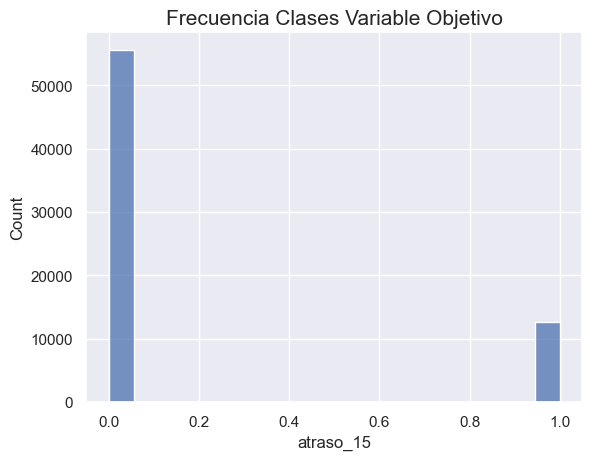

In [23]:
# Visualización frecuencia clases variable objetivo

sns.histplot(data=df, x='atraso_15')
plt.title('Frecuencia Clases Variable Objetivo', fontsize=15)

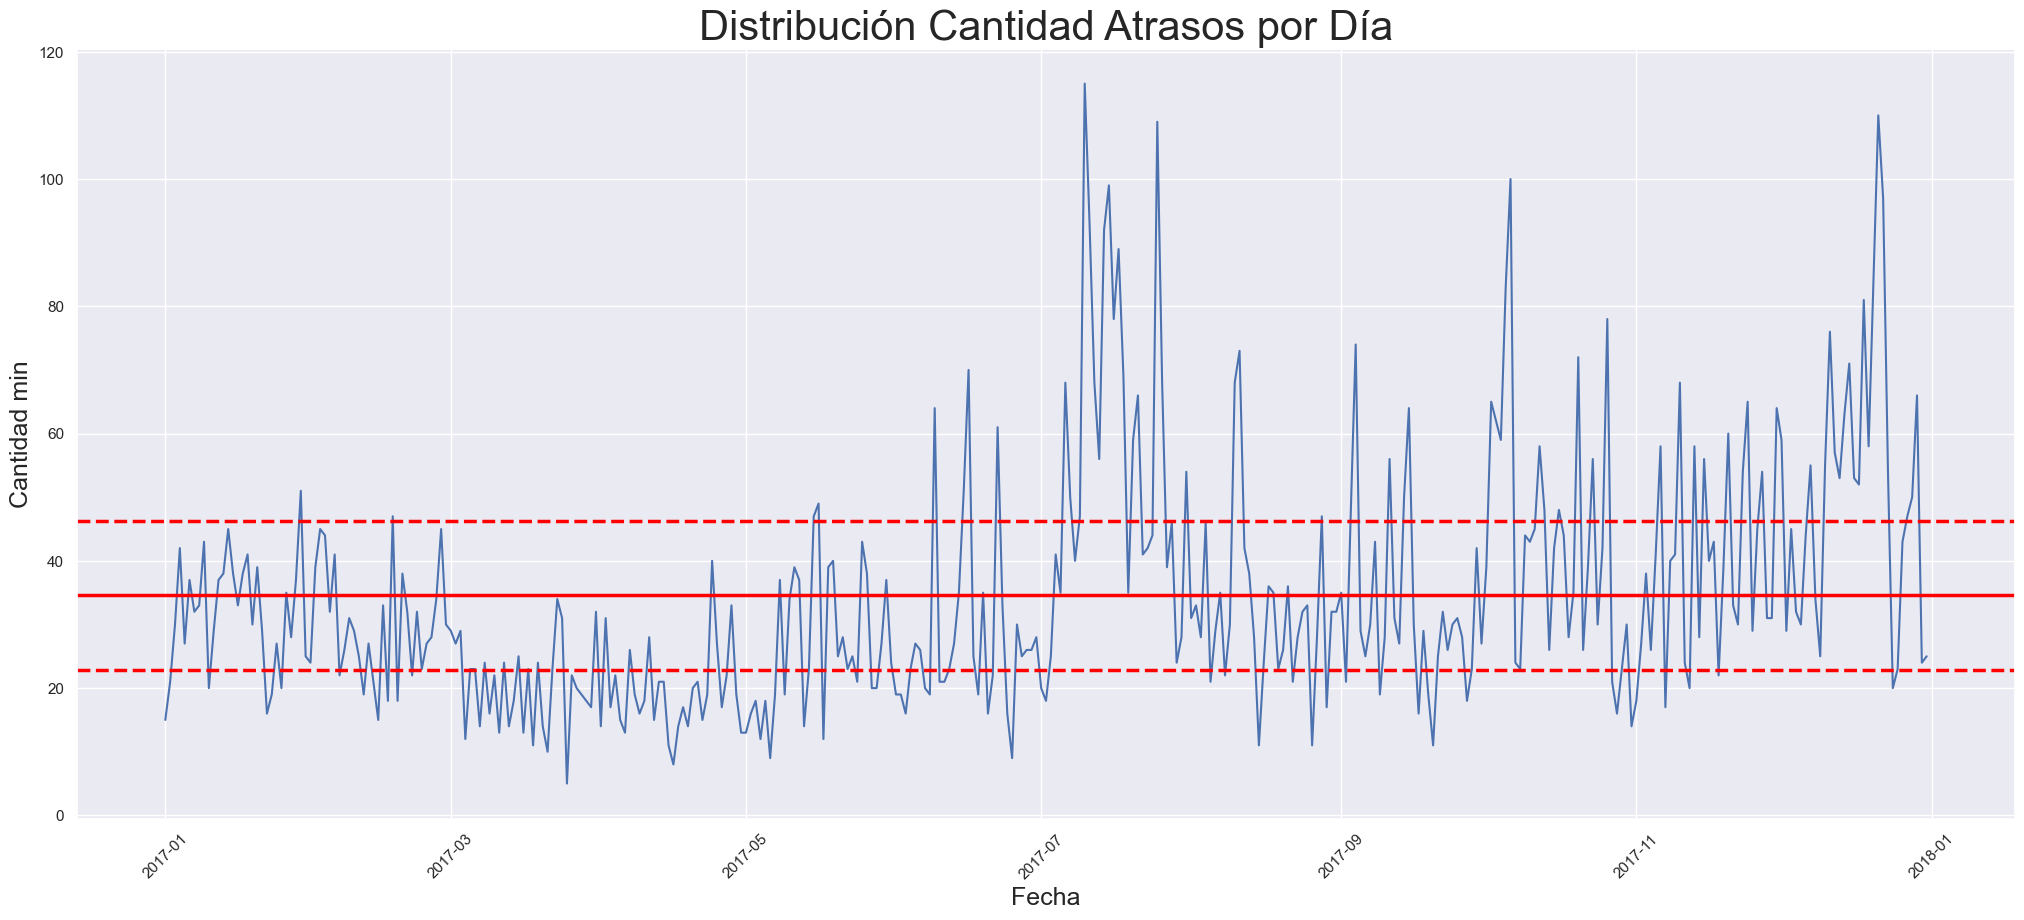

In [24]:
# Distribución de la cantidad de atrasos por día.

retrasos = df[df['diff_min']>0]
retrasos_cant = retrasos.groupby('Fecha-I').agg({'atraso_15':'sum'}).reset_index()
retrasos_cant.set_index('Fecha-I',inplace=True)
retrasos_cant = retrasos_cant.resample('D').sum()


# Calculo de la media y desviación estándar
m = np.mean(retrasos_cant['atraso_15'])
sd = np.std(retrasos_cant['atraso_15'])

#Calculo de intervalos de confianza
ci_low = m - (1.96*sd / np.sqrt(10))
ci_high = m + (1.96*sd / np.sqrt(10))

plt.figure(figsize=(25,10))
sns.lineplot(data=retrasos_cant, x="Fecha-I", y='atraso_15')
plt.axhline(y=m,
            color='red',
            ls='-', 
            lw=2.5)
plt.axhline(y=ci_low,
            color='red',
            ls='--', 
            lw=2.5)
plt.axhline(y=ci_high,
            color='red',
            ls='--', 
            lw=2.5)
plt.xlabel('Fecha', fontsize=18);
plt.ylabel('Cantidad min', fontsize=18);
plt.title('Distribución Cantidad Atrasos por Día', fontsize=30)
plt.xticks(rotation=45)
plt.show()

**Comentarios análisis gráfico Distribución Cantidad Atrasos por Día**

+ Se observa un incremento de los atrasos diarios en los meses de julio, octubre y diciembre.

+ La hipótesis del incremento para los meses de julio y octubre es el clima y para diciembre las festividades.

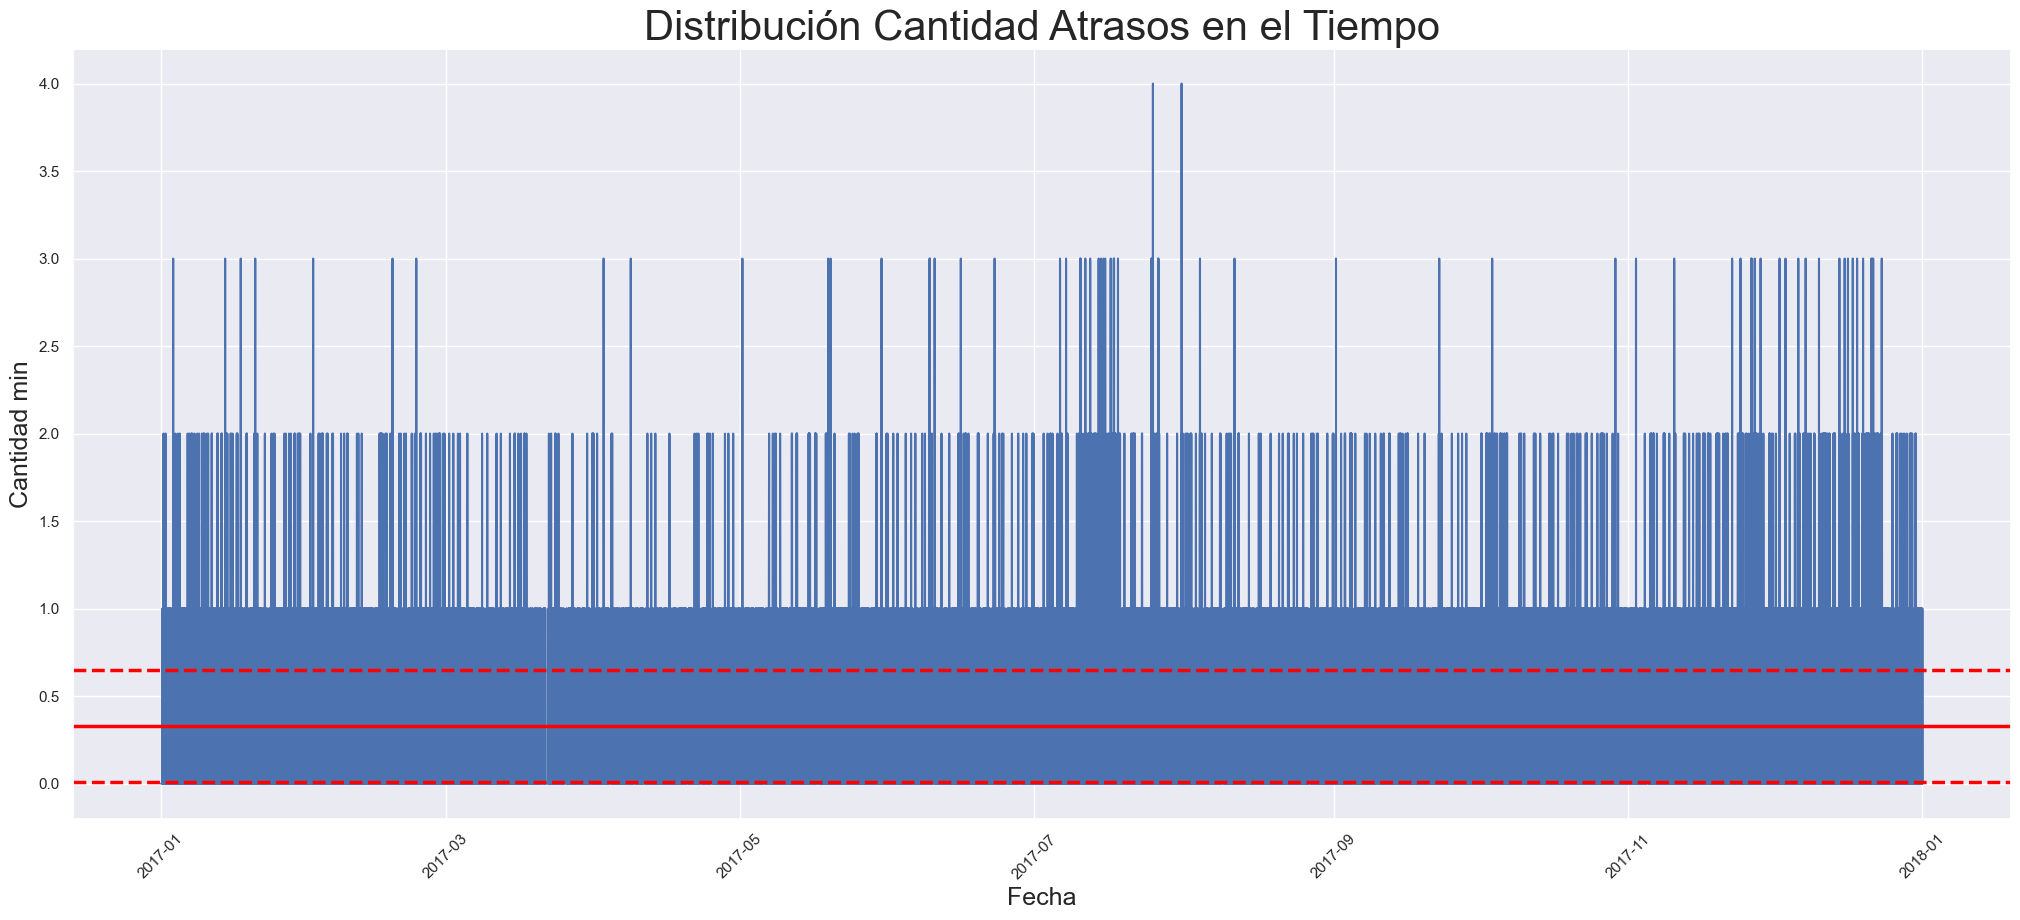

In [25]:
# Distribución de la cantidad de atrasos por día.

retrasos = df[df['diff_min']>0]
retrasos_cant = retrasos.groupby('Fecha-I').agg({'atraso_15':'sum'}).reset_index()
retrasos_cant.set_index('Fecha-I',inplace=True)
#retrasos_cant = retrasos_cant.resample('D').sum()


m = np.mean(retrasos_cant['atraso_15'])
sd = np.std(retrasos_cant['atraso_15'])

ci_low = m - (1.96*sd / np.sqrt(10))
ci_high = m + (1.96*sd / np.sqrt(10))

plt.figure(figsize=(25,10))
sns.lineplot(data=retrasos_cant, x="Fecha-I", y='atraso_15')
plt.axhline(y=m,
            color='red',
            ls='-', 
            lw=2.5)
plt.axhline(y=ci_low,
            color='red',
            ls='--', 
            lw=2.5)
plt.axhline(y=ci_high,
            color='red',
            ls='--', 
            lw=2.5)
plt.xlabel('Fecha', fontsize=18);
plt.ylabel('Cantidad min', fontsize=18);
plt.title('Distribución Cantidad Atrasos en el Tiempo', fontsize=30)
plt.xticks(rotation=45)
plt.show()

### 4.5 Análisis Exploratorio Considerando Variable Objetivo

In [26]:
# ¿Qué linea área es la que más se retrasa?


atrasos_emp = df.groupby('OPERA').agg({'atraso_15':'sum'})
atrasos_emp.reset_index(inplace=True)
atrasos_emp = atrasos_emp.sort_values(by='atraso_15',ascending=False)
 
atrasos_emp.head()

,OPERA,atraso_15
12,Grupo LATAM,7306
21,Sky Airline,2540
17,Latin American Wings,681
0,Aerolineas Argentinas,468
7,Avianca,306


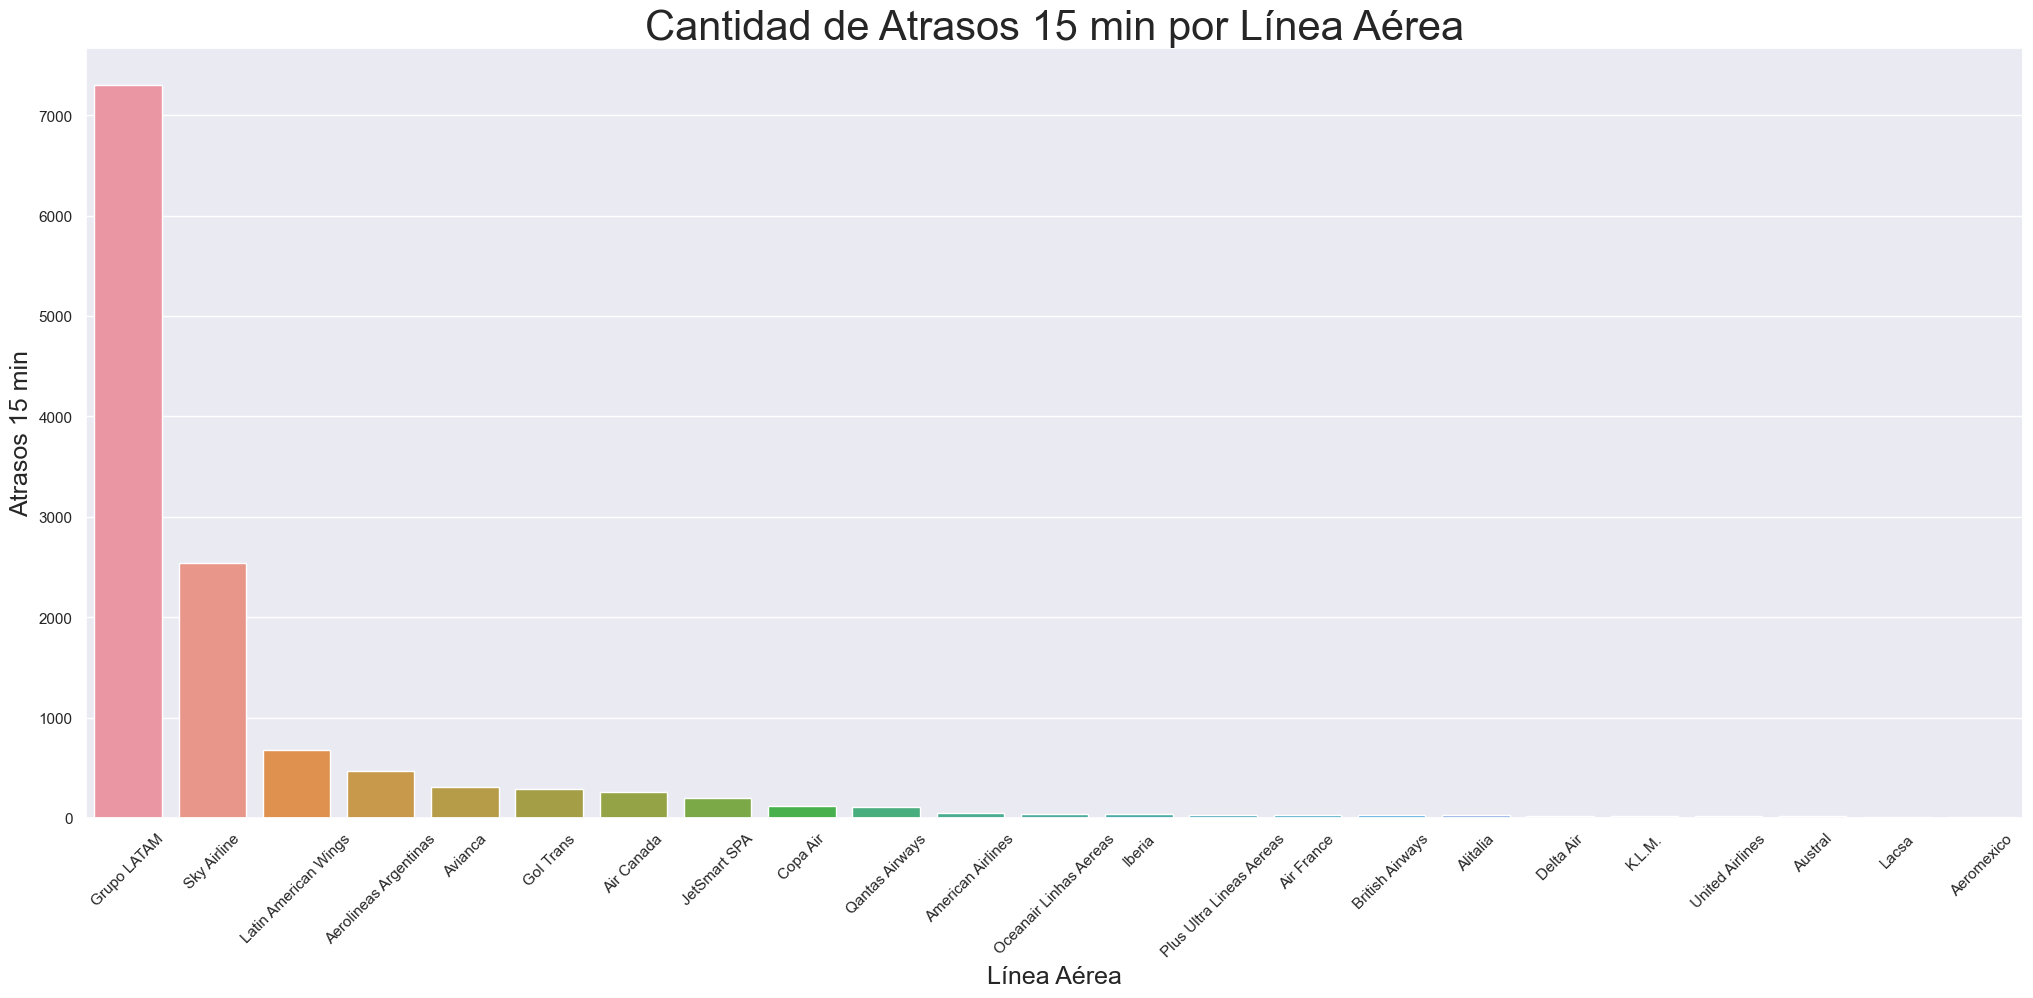

In [27]:
# Visualizar los frecuencia de atrasos por línea aérea

plt.figure(figsize=(25,10))
sns.barplot(data=atrasos_emp, x="OPERA", y='atraso_15')
plt.xlabel('Línea Aérea', fontsize=18);
plt.ylabel('Atrasos 15 min', fontsize=18);
plt.title('Cantidad de Atrasos 15 min por Línea Aérea', fontsize=30)
plt.xticks(rotation=45)
plt.show()

In [28]:
# Atrasos por línea aérea en relación a la cantidad de salidas


#Generación df cantidad de salidas por línea aérea
salidas = df.groupby('OPERA').agg({'atraso_15':'count'})
salidas.reset_index(inplace=True)
salidas = salidas.sort_values(by='atraso_15',ascending=False)
salidas.rename({'atraso_15':'cant_salidas'},axis=1,inplace=True)


atrasos_emp_porcentuales = pd.merge(atrasos_emp,salidas,how='left',on='OPERA')
atrasos_emp_porcentuales['porcentaje_atrasos'] = (atrasos_emp_porcentuales['atraso_15']/atrasos_emp_porcentuales['cant_salidas'])*100
atrasos_emp_porcentuales = atrasos_emp_porcentuales.sort_values(by='porcentaje_atrasos',ascending=False)

In [29]:
atrasos_emp_porcentuales.head()

,OPERA,atraso_15,cant_salidas,porcentaje_atrasos
13,Plus Ultra Lineas Aereas,30,49,61.224490
9,Qantas Airways,113,195,57.948718
6,Air Canada,258,565,45.663717
2,Latin American Wings,681,1674,40.681004
5,Gol Trans,287,806,35.607940


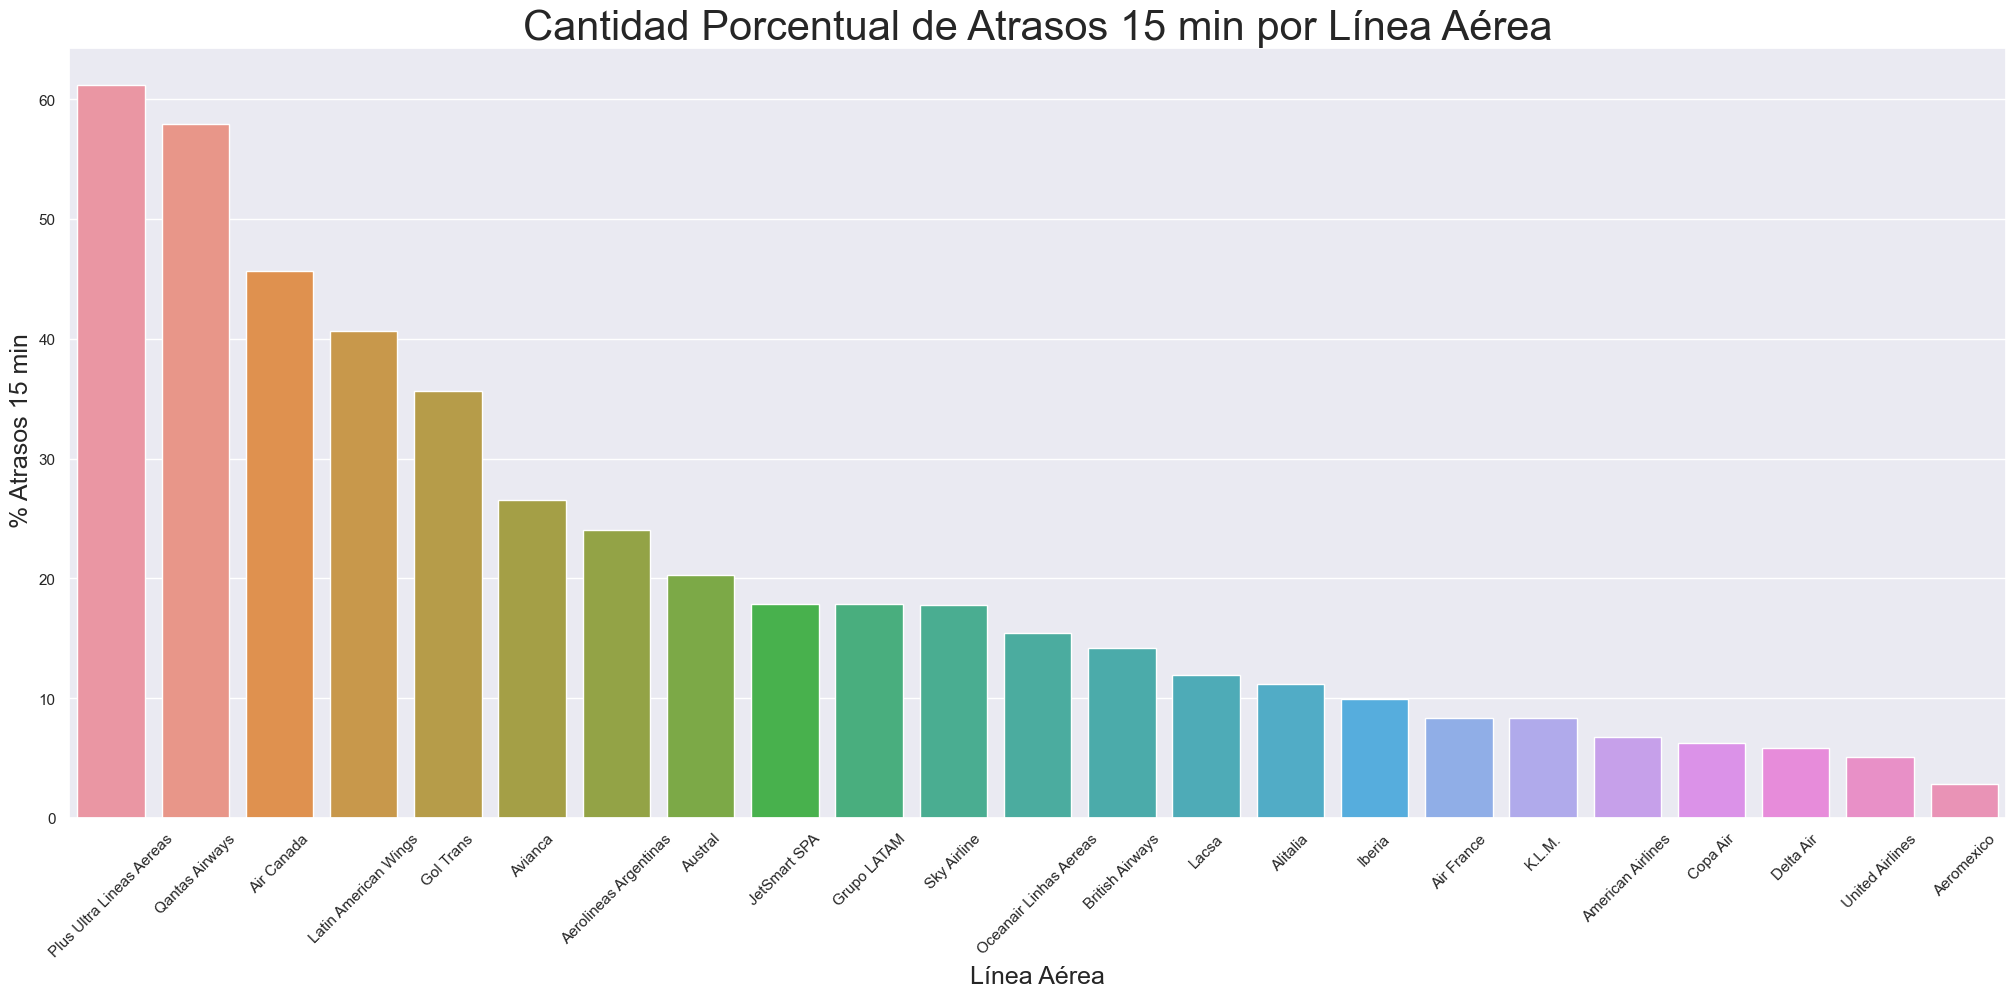

In [30]:
# Visualizar porcentaje de atrasos por línea aérea

plt.figure(figsize=(25,10))
sns.barplot(data=atrasos_emp_porcentuales, x="OPERA", y='porcentaje_atrasos')
plt.xlabel('Línea Aérea', fontsize=18);
plt.ylabel(' % Atrasos 15 min', fontsize=18);
plt.title('Cantidad Porcentual de Atrasos 15 min por Línea Aérea', fontsize=30)
plt.xticks(rotation=45)
plt.show()

### 5. Feature Engineering

In [31]:
df.columns

Index(['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
       'OPERA', 'SIGLAORI', 'SIGLADES', 'diff_des', 'diff_vlo', 'diff_emp',
       'diff_min', 'atraso_15'],
      dtype='object')

### 5.1 Creación Variables Recomendadas

In [32]:
# Función para la creación de la variable periodo_dia

def periodo_dia(x):
    """
    Asigna, de acuerdo al valor datetime de la columna a la que se le aplique la función, si este
    corresponde a mañana (05:00:00 a 11:59:00), tarde (12:00:00 a 18:59:00) o noche (19:00:00 a 23:59:00)
    
    x : valor en formato datetime.
    
    """
    if   (x.time() >= pd.to_datetime('05:00:00').time() and x.time() <= pd.to_datetime('11:59:00').time()):
        return 'mañana'
    elif (x.time() >= pd.to_datetime('12:00:00').time() and x.time() <= pd.to_datetime('18:59:00').time()):
        return 'tarde'
    elif (x.time() >= pd.to_datetime('19:00:00').time() and x.time() <= pd.to_datetime('23:59:00').time()):
        return 'noche'

In [33]:
# Generación de la variable periodo_dia

df['periodo_dia']  = df['Fecha-I'].apply(periodo_dia)

In [34]:
# Validación de la creación de la variable periodo_dia

df['periodo_dia'].value_counts()

tarde     25506
mañana    25352
noche     12455
Name: periodo_dia, dtype: int64

In [35]:
# Función para la creación de la variable recomendada temporada_alta

def temporada_alta(x):
    """
    Asigna, de acuerdo al valor datetime de la columna a la que se le aplique la función, si este
    corresponde a temporada alta.
    
    x : valor en formato datetime.
    """
    year = 2017
    
    if   (x.date().replace(year = year) >= pd.to_datetime(str(year)+ '-01-01').date() and x.date().replace(year = year) <= pd.to_datetime(str(year)+'-03-03').date()):
        return 1
    elif (x.date().replace(year = year) >= pd.to_datetime(str(year)+ '-07-15').date() and x.date().replace(year = year) <= pd.to_datetime(str(year)+'-07-31').date()):
        return 1
    elif (x.date().replace(year = year) >= pd.to_datetime(str(year)+ '-09-11').date() and x.date().replace(year = year) <= pd.to_datetime(str(year)+'-09-30').date()):
        return 1
    elif (x.date().replace(year = year) >= pd.to_datetime(str(year)+ '-12-15').date() and x.date().replace(year = year) <= pd.to_datetime(str(year)+'-12-31').date()):
        return 1
    else:
        return 0

In [36]:
# Generación de la variable temporada_alta

df['temporada_alta']  = df['Fecha-I'].apply(temporada_alta)

In [37]:
# Validación de la creación de la variable temporada_alta

df['temporada_alta'].value_counts()

0    45444
1    22762
Name: temporada_alta, dtype: int64

### 5.2 Creación Variables Adicionales

In [38]:
# Incorporación de la distancia desde SCL a los diferentes destinos. 
# Fuente https://www.airportdistancecalculator.com/flight-scl-to-zal.html#.Yz7lUC-xBN0

distancias = pd.read_excel(DATA/'distancias.xlsx')
distancias.set_index('destino',inplace=True)

In [39]:
# Unir datset distancia a dataset df

df = pd.merge(df,distancias,how='left',left_on='SIGLADES',right_on='destino')

In [40]:
# Incorporación datos meteorologícos por día. Estación meterologica Aeropuerto
# Fuente https://www.meteored.cl/tiempo-en_Santiago+de+Chile-America+Sur-Chile-Region+Metropolitana+de+Santiago-SCEL-sactual-18578.html
# meteochile.cl

clima = pd.read_excel(DATA/'clima_aeropuerto.xlsx')

In [41]:
# Generación de la llave para unir los datasets

df['fecha'] = df['Fecha-I'].apply(lambda x: pd.to_datetime(x.date()))

In [42]:
# Unir datset clima a dataset df

df = pd.merge(df,clima,how='left',on='fecha')

In [43]:
# Creación variables de diferencias climaticas

df['diff_temperatura'] = df['temperatura_maxima']-df['temperatura_minima']
df['diff_humedad'] = df['humedad_maxima']-df['humedad_minima']
df['diff_presion'] = df['presion_maxima']-df['presion_minima']

In [44]:
# Se mantienen las variables que muestran las diferencias entre las variables Des,Vlo y Emp.

In [45]:
# Se agregan variables relacionadas a los dias feriados

feriados = pd.read_csv(DATA/'res_feriados.csv',sep=';',parse_dates=['Fecha'],infer_datetime_format=True)

In [46]:
# Eliminar las filas con similar información en el df

feriados.drop(['mes','dia_semana'],axis=1,inplace=True)

In [47]:
# Unir datset feriados a dataset df

df = pd.merge(df,feriados,how='left',left_on='fecha',right_on='Fecha')

In [48]:
# Eliminar variables innecesarias

df.drop(['fecha','Fecha'],axis=1,inplace=True)

In [49]:
df.columns

Index(['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
       'OPERA', 'SIGLAORI', 'SIGLADES', 'diff_des', 'diff_vlo', 'diff_emp',
       'diff_min', 'atraso_15', 'periodo_dia', 'temporada_alta', 'distancia',
       'temperatura_maxima', 'temperatura_minima', 'humedad_maxima',
       'humedad_minima', 'presion_maxima', 'presion_minima',
       'velocidad_viento', 'agua_caida', 'diff_temperatura', 'diff_humedad',
       'diff_presion', 'feriado', 'previo_feriado', 'sandwich', 'fds_largo',
       'dia previo fds largo', 'dias_despues_feriado_largo'],
      dtype='object')

### 5.3 Análisis de las Variables Adicionales

In [50]:
# Crear dataframe con las variables adicionales

var_adicionales = df[['periodo_dia', 'temporada_alta', 'distancia',
                      'temperatura_maxima', 'temperatura_minima', 'humedad_maxima',
                      'humedad_minima', 'presion_maxima', 'presion_minima',
                      'velocidad_viento', 'agua_caida', 'diff_temperatura', 'diff_humedad',
                      'diff_presion','feriado', 'previo_feriado', 'sandwich', 'fds_largo',
                      'dia previo fds largo', 'dias_despues_feriado_largo']]

In [51]:
# Separar las variables adicionales en categóricas y numéricas

var_adicionales_cat = var_adicionales.select_dtypes(include=[object])
var_adicionales_num = var_adicionales.select_dtypes(include=[int,float])

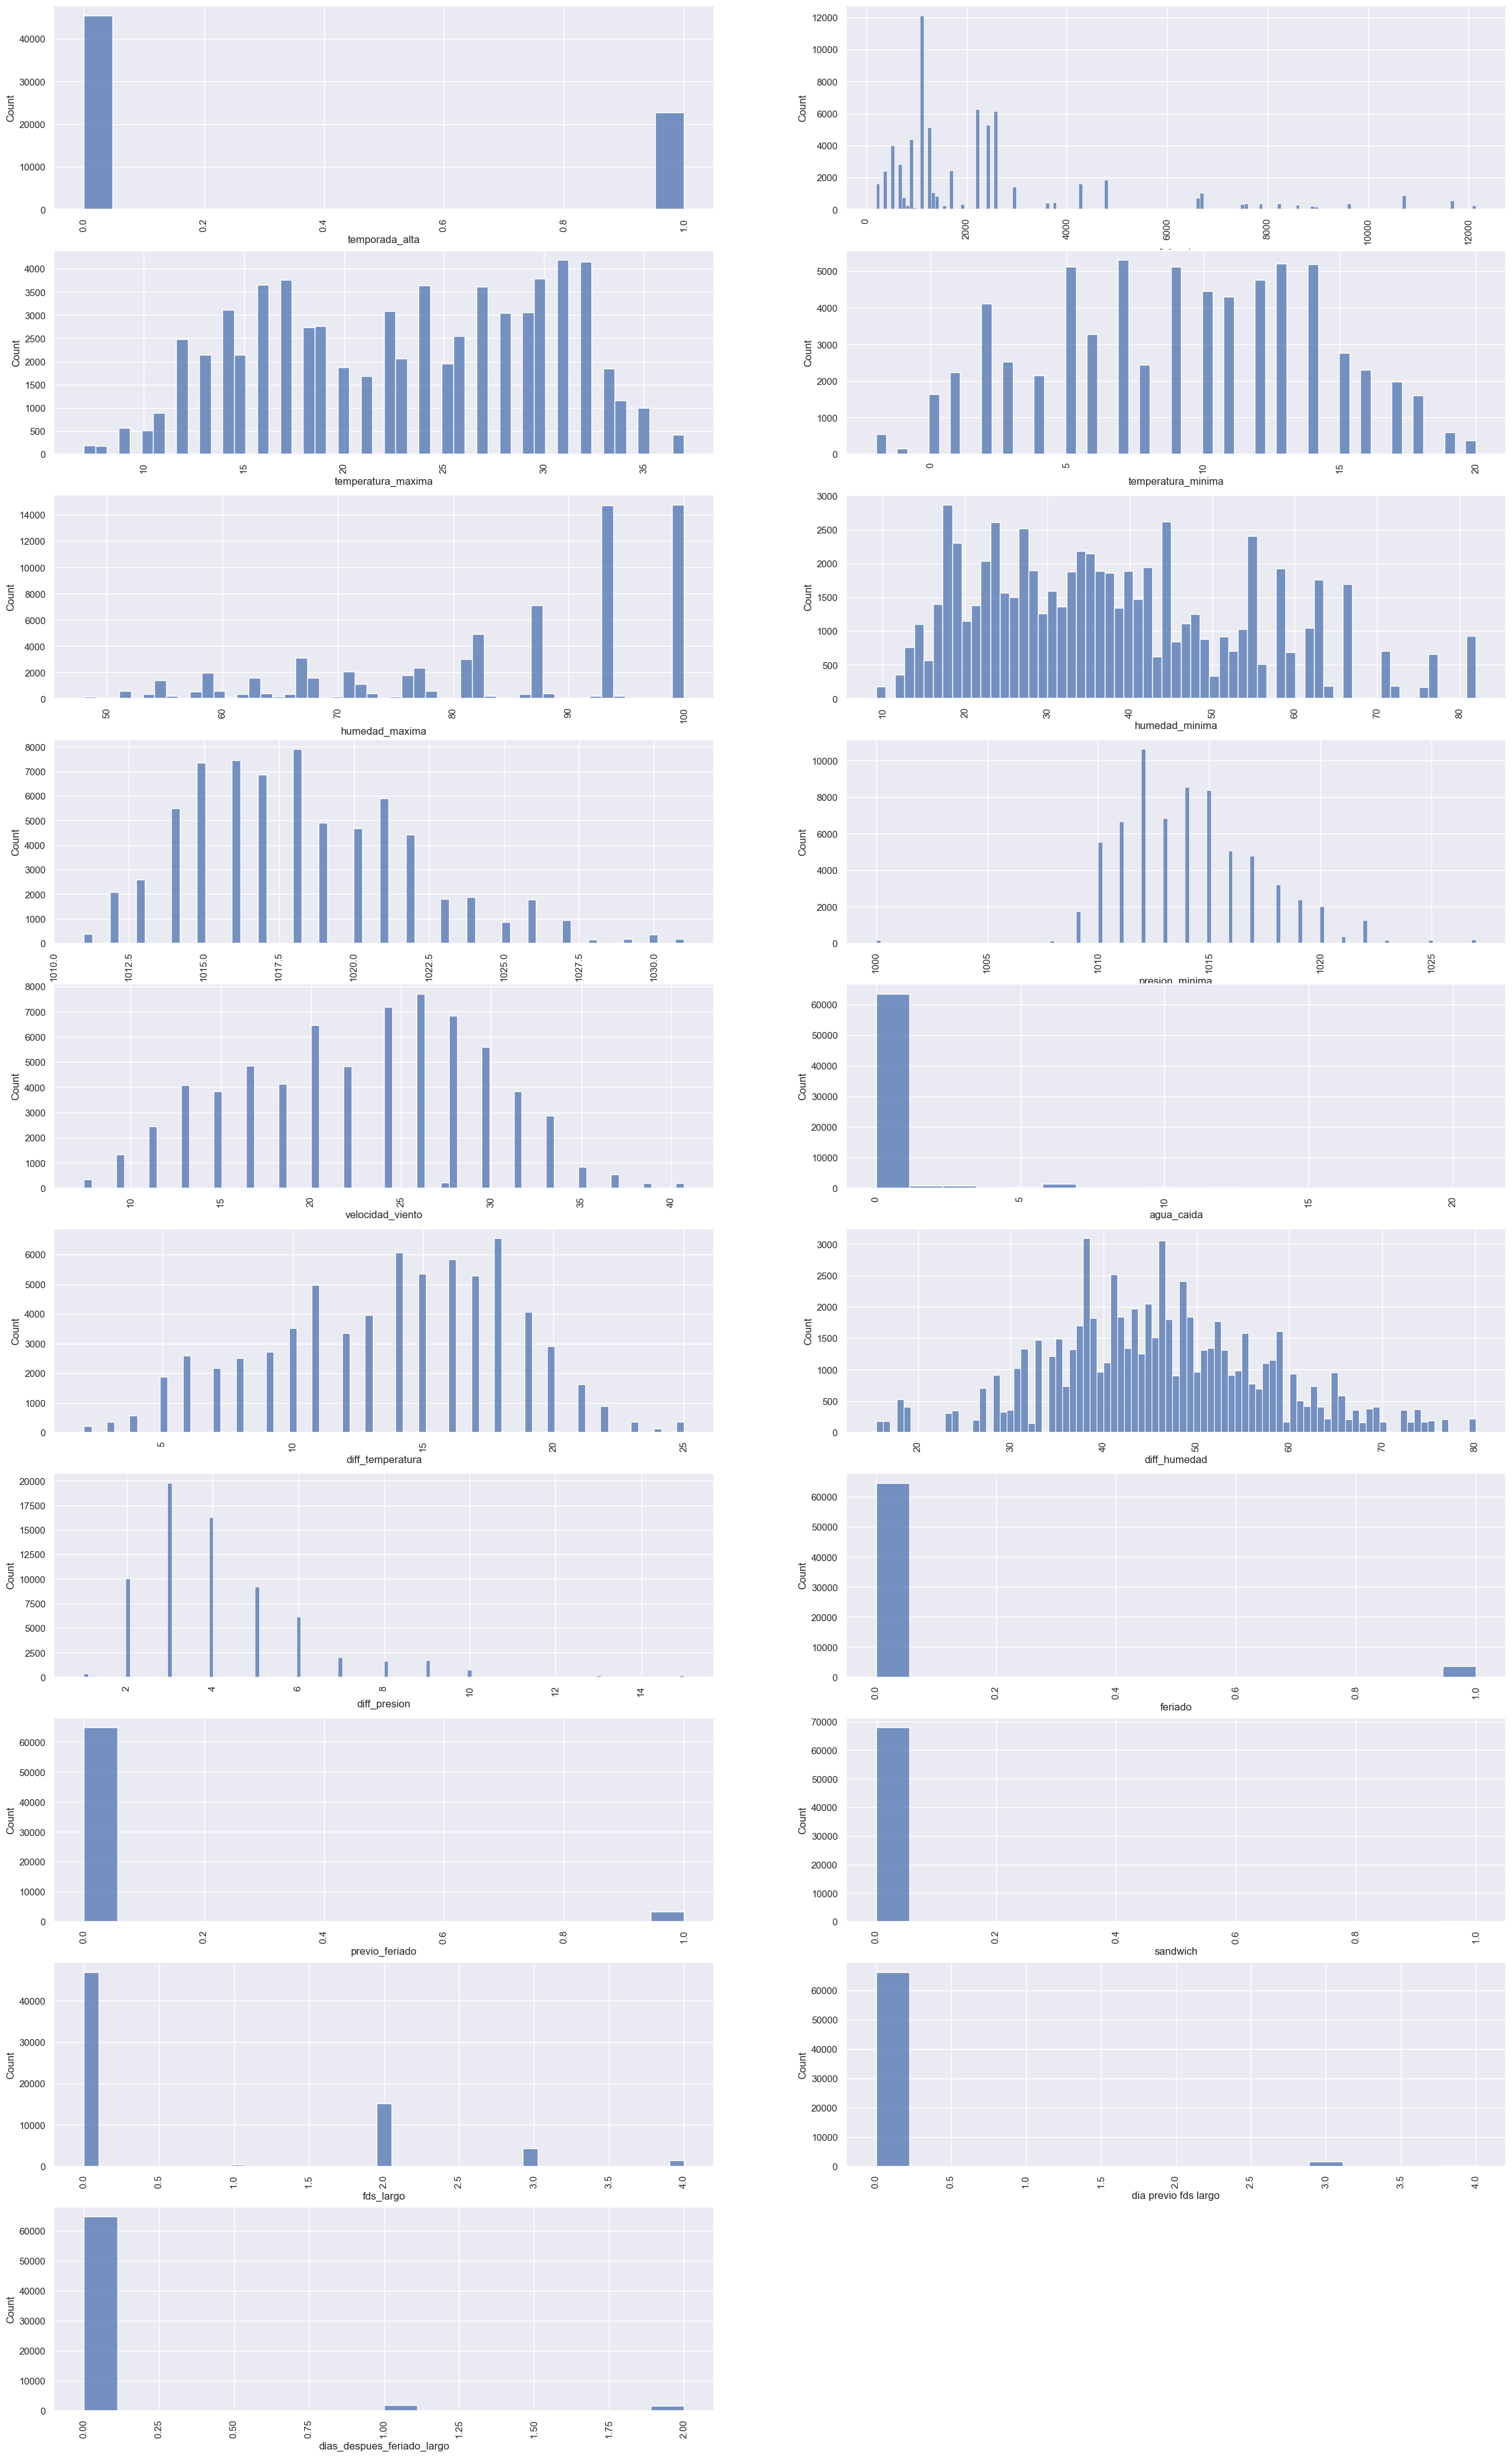

In [52]:
# Visualización variables adicionales numéricas


plt.figure(figsize=(30,50))

for i,col in enumerate(var_adicionales_num.columns,1):
    plt.subplot(10,2,i)
    sns.histplot(data=var_adicionales_num, x=col)
    plt.xticks(rotation=90)
plt.show()

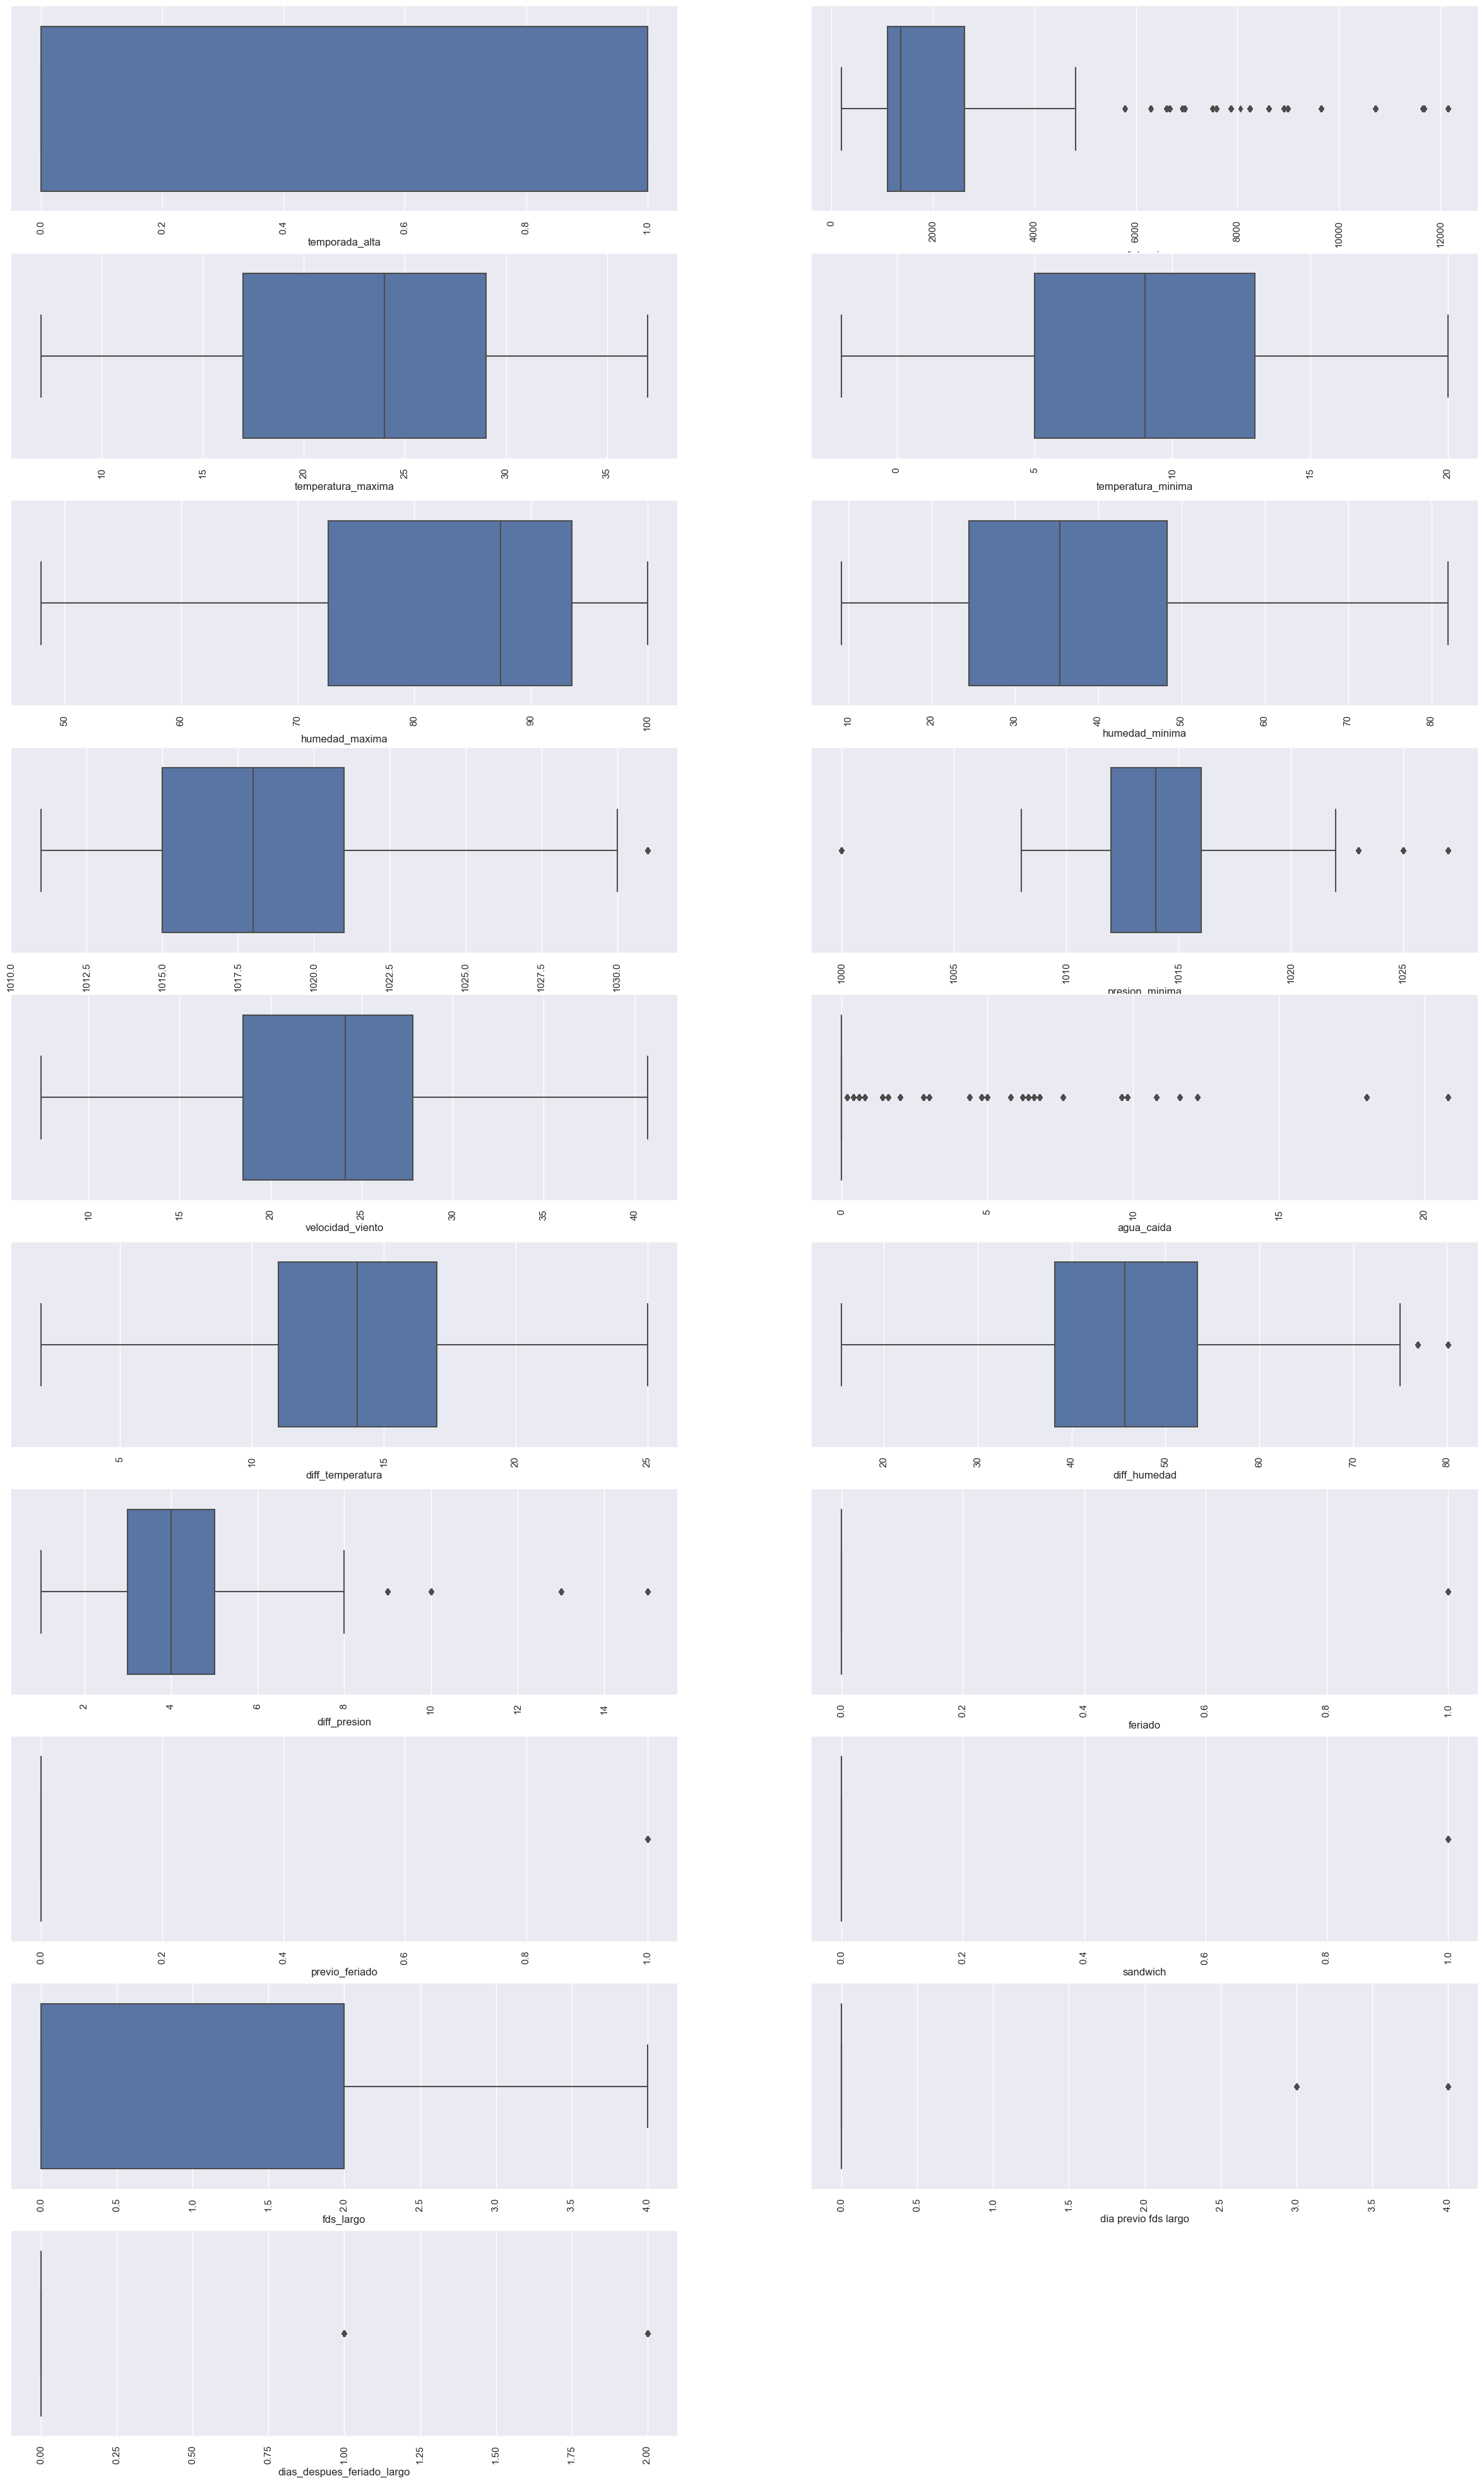

In [53]:
# Visualización boxplot para variables adicionales numéricas


plt.figure(figsize=(30,50))

for i,col in enumerate(var_adicionales_num.columns,1):
    plt.subplot(10,2,i)
    sns.boxplot(data=var_adicionales_num, x=col)
    plt.xticks(rotation=90)
plt.show()

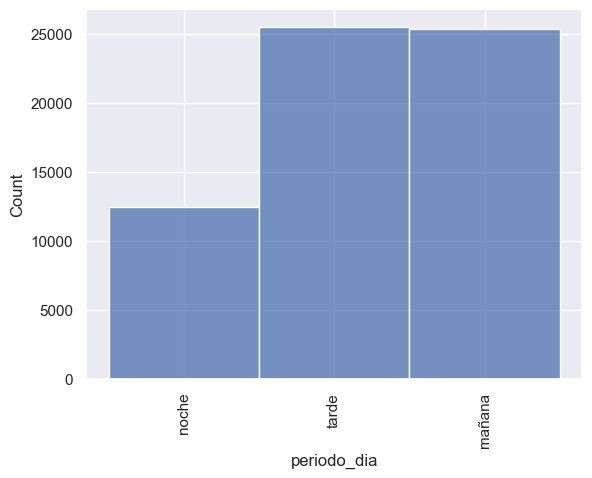

In [54]:
# Visualización variables adicionales categóricas


sns.histplot(data=var_adicionales_cat, x='periodo_dia')
plt.xticks(rotation=90)
plt.show()

### 5.4 Transformación de variables

In [55]:
# Transformación logaritmica en variables numéricas que no presentan una distribución cercana a la normal

df['log_agua_caida'] = np.log(df['agua_caida'])
df['log_distancia'] = np.log(df['distancia'])

In [56]:
df['log_agua_caida'] = df['log_agua_caida'].apply(lambda x: 0 if x==-np.inf else x)
df['log_distancia']  = df['log_distancia'] .apply(lambda x: 0 if x==-np.inf else x)

df['log_agua_caida'] = df['log_agua_caida'].apply(lambda x: 0 if x==np.inf else x)
df['log_distancia']  = df['log_distancia'] .apply(lambda x: 0 if x==np.inf else x)

<AxesSubplot: xlabel='log_agua_caida', ylabel='Count'>

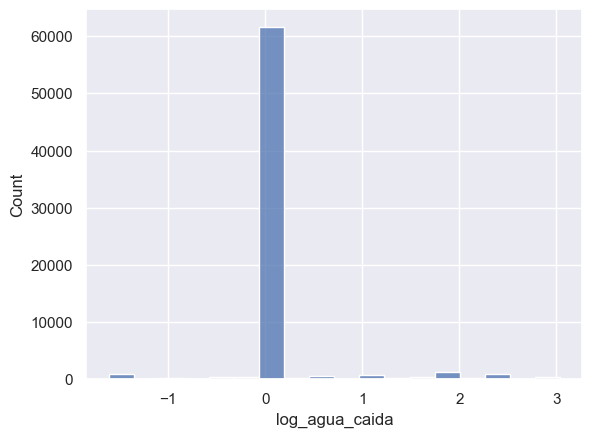

In [57]:
# Visualización de la variable agua_caida transformada

sns.histplot(data=df, x='log_agua_caida')

<AxesSubplot: xlabel='log_distancia', ylabel='Count'>

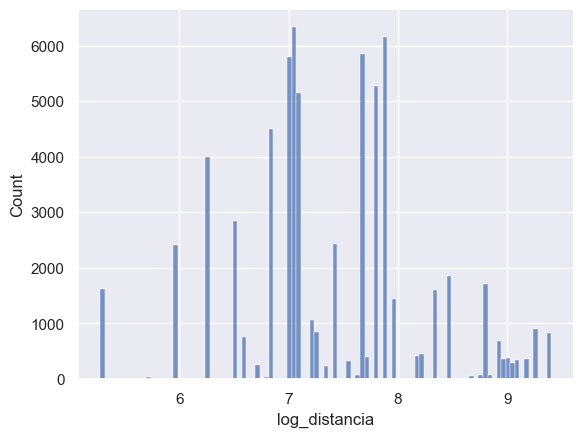

In [58]:
# Visualización de la variable distancia transformada

sns.histplot(data=df, x='log_distancia')

In [59]:
# Eliminación de las variables originales

df = df.drop({'agua_caida','distancia'},axis=1)

In [60]:
df.columns

Index(['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
       'OPERA', 'SIGLAORI', 'SIGLADES', 'diff_des', 'diff_vlo', 'diff_emp',
       'diff_min', 'atraso_15', 'periodo_dia', 'temporada_alta',
       'temperatura_maxima', 'temperatura_minima', 'humedad_maxima',
       'humedad_minima', 'presion_maxima', 'presion_minima',
       'velocidad_viento', 'diff_temperatura', 'diff_humedad', 'diff_presion',
       'feriado', 'previo_feriado', 'sandwich', 'fds_largo',
       'dia previo fds largo', 'dias_despues_feriado_largo', 'log_agua_caida',
       'log_distancia'],
      dtype='object')

In [61]:
df1 = df[['DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
       'OPERA', 'SIGLAORI', 'SIGLADES', 'diff_des', 'diff_vlo', 'diff_emp',
       'diff_min', 'atraso_15', 'periodo_dia', 'temporada_alta',
       'temperatura_maxima', 'temperatura_minima', 'humedad_maxima',
       'humedad_minima', 'presion_maxima', 'presion_minima',
       'velocidad_viento', 'diff_temperatura', 'diff_humedad', 'diff_presion',
       'feriado', 'previo_feriado', 'sandwich', 'fds_largo',
       'dia previo fds largo', 'dias_despues_feriado_largo', 'log_agua_caida',
       'log_distancia']]

In [62]:
y = df1['atraso_15']
X = df1.drop(columns=['atraso_15'])

In [63]:
# Separación en train y test

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 123,test_size=0.30)

In [64]:
# Se identifica el nombre de las columnas numéricas y categóricas

cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()

# Se aplica one-hot-encoding solo a las columnas categóricas

preprocessor = ColumnTransformer(
                    [('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                    remainder='passthrough'
               )

# Una vez que se ha definido el objeto ColumnTransformer, con el método fit()
# se aprenden las transformaciones con los datos de entrenamiento y se aplican a
# los dos conjuntos con transform(). Ambas operaciones a la vez con fit_transform().
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

# Convertir el output del ColumnTransformer en dataframe y añadir nombre columnas
# ==============================================================================
# Nombre de todas las columnas
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names(cat_cols)
labels = np.concatenate([encoded_cat,numeric_cols])

# Conversión a dataframe
X_train_prep = pd.DataFrame((X_train_prep.toarray()), columns=labels)
X_test_prep  = pd.DataFrame(X_test_prep.toarray(), columns=labels)

In [65]:
clf = LogisticRegression(random_state=0)
clf.fit(X_train_prep,y_train)

LogisticRegression(random_state=0)

In [68]:
predicciones = clf.predict(X = X_test_prep)

In [70]:
mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print("-------------------")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} %")

Matriz de confusión
-------------------
[[16678     0]
 [    0  3784]]

El accuracy de test es: 100.0 %


In [69]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicciones)
metrics.auc(fpr, tpr)

1.0

In [71]:
modelo = RandomForestClassifier(random_state = 123)

modelo.fit(X_train_prep,y_train)

# Error de test del modelo final
# ==============================================================================
predicciones = modelo.predict(X = X_test_prep)

mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print("-------------------")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} %")

Matriz de confusión
-------------------
[[16678     0]
 [    0  3784]]

El accuracy de test es: 100.0 %
